In [1]:
import pandas as pd
import numpy as np
import glob as glob
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, DrawingArea, OffsetImage, AnnotationBbox
from scipy.signal import butter, lfilter
from scipy.signal import butter, filtfilt
import os
from pathlib import Path

Import Files

Import all files from specified folder and assign the compounds applied in each. Folder should only contain files from a single plate and single injection, the datatable and trace for each.

In [47]:
path =r'/Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211'
data_tables = glob.glob(path + "/*Datatable*.dat") # use your extension
traces = glob.glob(path + "/*Traces*.dat") # use your extension

li = []
li2 = pd.DataFrame()

for filename in data_tables:
    df = pd.read_csv(filename, index_col=None, header=0, sep='\t') # for .dat files you must specify separation for example sep='\t'
    # Extract only the filename without folder information
    filename = os.path.basename(filename)
    # Create a DataFrame with a single column containing the filename
    filename_df = pd.DataFrame({'Filename': [filename] * len(df)})
    # Create a DataFrame with a single column containing the filename
    filename_df = pd.DataFrame({'Filename': [filename] * len(df)})
    # Concatenate the filename DataFrame with your existing DataFrame along columns
    df = pd.concat([filename_df, df], axis=1)
    li.append(df)

for filename in traces:
    df_trace = pd.read_csv(filename, index_col=None, header=0, sep='\t') # for .dat files you must specify separation for example sep='\t'
    #Iterate over columns and prepend filename to each header
    for column in df_trace.columns:
        # Extract only the filename without folder information
        filename = os.path.basename(filename)
        df_trace.rename(columns={column: f"{filename}_{column}"}, inplace=True)
    li2 = pd.concat([li2, df_trace], axis=1)

data_table = pd.concat(li, axis=0, ignore_index=True)
li2.head(5)

,14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1_Export_Traces.dat_Time(ms)_RecordingID-99,14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1_Export_Traces.dat_J(nA)_RecordingID-99,14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1_Export_Traces.dat_Time(ms)_RecordingID-100,14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1_Export_Traces.dat_J(nA)_RecordingID-100,14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1_Export_Traces.dat_Time(ms)_RecordingID-101,14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1_Export_Traces.dat_J(nA)_RecordingID-101,14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1_Export_Traces.dat_Time(ms)_RecordingID-102,14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1_Export_Traces.dat_J(nA)_RecordingID-102,14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1_Export_Traces.dat_Time(ms)_RecordingID-103,14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1_Export_Traces.dat_J(nA)_RecordingID-103,...,07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2_Export_Traces.dat_Time(ms)_RecordingID-61,07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2_Export_Traces.dat_J(nA)_RecordingID-61,07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2_Export_Traces.dat_Time(ms)_RecordingID-62,07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2_Export_Traces.dat_J(nA)_RecordingID-62,07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2_Export_Traces.dat_Time(ms)_RecordingID-63,07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2_Export_Traces.dat_J(nA)_RecordingID-63,07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2_Export_Traces.dat_Time(ms)_RecordingID-64,07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2_Export_Traces.dat_J(nA)_RecordingID-64,07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2_Export_Traces.dat_Time(ms)_RecordingID-65,07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2_Export_Traces.dat_J(nA)_RecordingID-65
0,0.0,-0.2,0.0,-0.7,0.0,-0.1,0.0,0.2,0.0,0.3,...,0.0,-0.1,0.0,0.6,0.0,0.1,0.0,0.2,0.0,0.9
1,2.0,-0.1,2.0,0.3,2.0,0.2,2.0,-1.3,2.0,-1.2,...,2.0,-1.3,2.0,-0.2,2.0,0.0,2.0,-0.5,2.0,-0.9
2,4.0,-1.5,4.0,-1.0,4.0,-0.5,4.0,-0.2,4.0,-0.1,...,4.0,-2.5,4.0,-0.2,4.0,-0.8,4.0,-0.6,4.0,-1.6
3,6.0,-0.4,6.0,-0.6,6.0,0.5,6.0,-0.2,6.0,-1.2,...,6.0,-1.3,6.0,0.0,6.0,1.0,6.0,0.3,6.0,-1.6
4,8.0,-1.5,8.0,-0.9,8.0,1.6,8.0,0.1,8.0,-0.9,...,8.0,-3.0,8.0,0.3,8.0,0.4,8.0,-0.5,8.0,-1.0


In [48]:
duplicate_columns = li2.columns[li2.columns.duplicated()]

if len(duplicate_columns) == 0:
    print("No duplicated column names.")
else:
    print("Duplicated column names:", duplicate_columns.tolist())

No duplicated column names.


In [49]:
# Column names based on the standard column titles from Robocyte2+ software export
selected_columns = ['Well', 'Buffer', 'Comp. 1', 'conc. 1', 'unit 1', 'Minimum', 'Baseline Average', 'ID','Filename']

# Select columns and create a copy to avoid chained assignment warning
data_table_info = data_table[selected_columns].copy()

# Transform units to µM scale
conditions = [
    (data_table_info['unit 1'] == 'mM'),
    (data_table_info['unit 1'] == 'µM'),
    (data_table_info['unit 1'] == 'nM')
]

choices = ['1000', '1', '0.001']

# Use .loc to set values for the 'factor' column
data_table_info.loc[:, 'factor'] = np.select(conditions, choices, default='0').astype(float)

# Use .loc to set values for the 'Agonist_Concentration_µM' column
data_table_info.loc[:, 'Agonist_Concentration_µM'] = data_table_info['conc. 1'] * data_table_info['factor']

# Select final columns
final_columns = ['Well', 'Buffer', 'Comp. 1', 'Minimum', 'Agonist_Concentration_µM', 'ID','Filename']
data_table_info = data_table_info[final_columns]

# Remove '.dat' part from strings in the 'Filename' column
data_table_info['Filename'] = data_table_info['Filename'].str.replace('_Export_Datatable.dat', '')

# Reset index
data_table_info.reset_index(drop=True, inplace=True)
# Assuming data_table_info is your DataFrame
# Convert integer columns to strings and concatenate them
data_table_info['Unique_Trace_ID'] = data_table_info['Well'].astype(str) + '_' + data_table_info['Comp. 1'].astype(str) + '_' + data_table_info['ID'].astype(str)+ '_'+data_table_info['Filename'].astype(str)

data_table_info.head(100)

/var/folders/dq/ywz90syj7gd0yltqn3vxb0sc0000gn/T/ipykernel_91569/3204934782.py:27: FutureWarning: The default value of regex will change from True to False in a future version.
  data_table_info['Filename'] = data_table_info['Filename'].str.replace('_Export_Datatable.dat', '')


,Well,Buffer,Comp. 1,Minimum,Agonist_Concentration_µM,ID,Filename,Unique_Trace_ID
0,C1,ND96,Ach,-2690,1000.0,33,07July23_Screening_P3_pAC210_211_Rat_Alpha9+10...,C1_Ach_33_07July23_Screening_P3_pAC210_211_Rat...
1,C1,ND96,Choline,-229,1000.0,34,07July23_Screening_P3_pAC210_211_Rat_Alpha9+10...,C1_Choline_34_07July23_Screening_P3_pAC210_211...
2,C1,ND96,Betaine,-2,1000.0,35,07July23_Screening_P3_pAC210_211_Rat_Alpha9+10...,C1_Betaine_35_07July23_Screening_P3_pAC210_211...
3,C1,ND96,5HT,-14,1000.0,36,07July23_Screening_P3_pAC210_211_Rat_Alpha9+10...,C1_5HT_36_07July23_Screening_P3_pAC210_211_Rat...
4,C1,ND96,Octo,-5,1000.0,37,07July23_Screening_P3_pAC210_211_Rat_Alpha9+10...,C1_Octo_37_07July23_Screening_P3_pAC210_211_Ra...
...,...,...,...,...,...,...,...,...
61,C2,ND96,Glycine,-4,1000.0,105,14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_Glycine_105_14Dec23_P1_pAC210_211_Rat_Alpha...
62,C2,ND96,Glut,-5,1000.0,106,14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_Glut_106_14Dec23_P1_pAC210_211_Rat_Alpha9+1...
63,C2,ND96,Betaine,-2,1000.0,107,14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_Betaine_107_14Dec23_P1_pAC210_211_Rat_Alpha...
64,C2,ND96,Choline,-112,1000.0,108,14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_Choline_108_14Dec23_P1_pAC210_211_Rat_Alpha...


In [50]:
#remove time columns from df_traces
# Filter columns in df_trace that do not include the string 'Time'
df_trace = li2[[col for col in li2.columns if 'Time' not in col]]

In [51]:
# Iterate over headers of df_trace
for header in df_trace.columns:

    
    # Extract the beginning part before '.dat' and the part after '-'
    prefix, suffix = header.split('.dat')[0], header.split('-')[-1]
    # Remove 'Export_Traces' from the end of prefix
    prefix = prefix.rstrip('_Export_Traces')
    # Convert suffix to integer
    suffix = int(suffix.strip())  # Ensure no leading or trailing whitespaces
    print(prefix)
    print(suffix)

    # Find the row in data_table_info where both prefix and suffix match
    matching_row = data_table_info[(data_table_info['Filename'].str.strip() == prefix.strip()) & (data_table_info['ID'] == suffix)]
    print(matching_row)
  
    # If a matching row is found, rename the header of df_trace
    if not matching_row.empty:
        unique_trace_id = matching_row['Unique_Trace_ID'].iloc[0]
        old_header_name = header
        new_header_name = unique_trace_id
        df_trace.rename(columns={header: unique_trace_id}, inplace=True)
        print(f"Renamed column '{old_header_name}' to '{new_header_name}'")


14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1
99
   Well Buffer Comp. 1  Minimum  Agonist_Concentration_µM  ID  \
55   C2   ND96     5HT       -5                    1000.0  99   

                                     Filename  \
55  14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1   

                                      Unique_Trace_ID  
55  C2_5HT_99_14Dec23_P1_pAC210_211_Rat_Alpha9+10_...  
Renamed column '14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1_Export_Traces.dat_J(nA)_RecordingID-99' to 'C2_5HT_99_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1'
14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1
100
   Well Buffer Comp. 1  Minimum  Agonist_Concentration_µM   ID  \
56   C2   ND96    Octo       -4                    1000.0  100   

                                     Filename  \
56  14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1   

                                      Unique_Trace_ID  
56  C2_Octo_100_14Dec23_P1_pAC210_211_Rat_Alpha9+1...  
Renamed column '14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1_Export_Tra

/var/folders/dq/ywz90syj7gd0yltqn3vxb0sc0000gn/T/ipykernel_91569/734381706.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trace.rename(columns={header: unique_trace_id}, inplace=True)
/var/folders/dq/ywz90syj7gd0yltqn3vxb0sc0000gn/T/ipykernel_91569/734381706.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trace.rename(columns={header: unique_trace_id}, inplace=True)
/var/folders/dq/ywz90syj7gd0yltqn3vxb0sc0000gn/T/ipykernel_91569/734381706.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pa

   Well Buffer   Comp. 1  Minimum  Agonist_Concentration_µM  ID  \
28   C3   ND96  Dopamine      -50                    1000.0  61   

                                             Filename  \
28  07July23_Screening_P3_pAC210_211_Rat_Alpha9+10...   

                                      Unique_Trace_ID  
28  C3_Dopamine_61_07July23_Screening_P3_pAC210_21...  
Renamed column '07July23_Screening_P3_pAC210_211_Rat_Alpha9+10_Robo1_Export_Traces.dat_J(nA)_RecordingID-61' to 'C3_Dopamine_61_07July23_Screening_P3_pAC210_211_Rat_Alpha9+10_Robo1'
07July23_Screening_P3_pAC210_211_Rat_Alpha9+10_Robo1
62
   Well Buffer      Comp. 1  Minimum  Agonist_Concentration_µM  ID  \
29   C3   ND96  Epinephrine      -74                    1000.0  62   

                                             Filename  \
29  07July23_Screening_P3_pAC210_211_Rat_Alpha9+10...   

                                      Unique_Trace_ID  
29  C3_Epinephrine_62_07July23_Screening_P3_pAC210...  
Renamed column '07July23_Screeni

/var/folders/dq/ywz90syj7gd0yltqn3vxb0sc0000gn/T/ipykernel_91569/734381706.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trace.rename(columns={header: unique_trace_id}, inplace=True)
/var/folders/dq/ywz90syj7gd0yltqn3vxb0sc0000gn/T/ipykernel_91569/734381706.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trace.rename(columns={header: unique_trace_id}, inplace=True)
/var/folders/dq/ywz90syj7gd0yltqn3vxb0sc0000gn/T/ipykernel_91569/734381706.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pa

In [52]:

# Reset the index if needed
df_trace.reset_index(drop=True, inplace=True)
df_trace.columns.name = 'Time (ms)'
df_trace.head()
# Convert 'ID' column to int64 in data_traces
#data_traces['ID'] = data_traces['ID'].astype(int)
# Merging on the 'ID' column
#merged_data = pd.merge(data_table_info, data_traces, on='ID')
#merged_data['new_col_header'] = merged_data['Well'] + '_' + merged_data['Comp. 1'] + '_' + merged_data['ID'].astype(str)
#merged_data.head(100)


Time (ms),C2_5HT_99_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_Octo_100_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_Tyra_101_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_Dopamine_102_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_Histamine_103_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_GABA_104_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_Glycine_105_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_Glut_106_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_Betaine_107_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_Choline_108_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,...,C10_Glycine_56_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2,C10_d-serine_57_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2,C10_B-alanine_58_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2,C10_Lysine_59_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2,C10_Glutamate_60_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2,C10_GABA_61_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2,C10_pH4.5_62_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2,C10_Aspartate_63_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2,C10_Taurine_64_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2,C10_L-arginine_65_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2
0,-0.2,-0.7,-0.1,0.2,0.3,-0.7,-0.3,1.1,0.7,1.5,...,-0.9,1.2,0.4,-0.2,-0.6,-0.1,0.6,0.1,0.2,0.9
1,-0.1,0.3,0.2,-1.3,-1.2,-1.2,0.5,0.8,0.5,1.2,...,-0.8,1.1,0.9,-0.5,-0.9,-1.3,-0.2,0.0,-0.5,-0.9
2,-1.5,-1.0,-0.5,-0.2,-0.1,-0.4,-1.4,-0.2,-0.2,0.7,...,-0.1,1.7,0.6,0.3,-0.8,-2.5,-0.2,-0.8,-0.6,-1.6
3,-0.4,-0.6,0.5,-0.2,-1.2,1.0,0.9,0.7,0.9,0.6,...,0.8,1.7,-0.2,-0.1,-1.2,-1.3,0.0,1.0,0.3,-1.6
4,-1.5,-0.9,1.6,0.1,-0.9,0.6,-1.3,0.4,0.6,1.4,...,1.3,0.4,-0.4,0.0,0.2,-3.0,0.3,0.4,-0.5,-1.0


In [53]:
# Find the first occurrence of NaN in each column
first_nan_indices = df_trace.apply(lambda col: col.isna().idxmax() if col.isna().any() else len(col))

# Get the minimum index where NaN first appears in any column
min_index = min(first_nan_indices)

# Slice the DataFrame to keep only rows before the first NaN occurrence
df_trace_cleaned = df_trace.iloc[:min_index]
df_trace_cleaned.head(100)

Time (ms),C2_5HT_99_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_Octo_100_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_Tyra_101_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_Dopamine_102_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_Histamine_103_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_GABA_104_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_Glycine_105_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_Glut_106_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_Betaine_107_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_Choline_108_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,...,C10_Glycine_56_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2,C10_d-serine_57_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2,C10_B-alanine_58_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2,C10_Lysine_59_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2,C10_Glutamate_60_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2,C10_GABA_61_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2,C10_pH4.5_62_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2,C10_Aspartate_63_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2,C10_Taurine_64_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2,C10_L-arginine_65_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2
0,-0.2,-0.7,-0.1,0.2,0.3,-0.7,-0.3,1.1,0.7,1.5,...,-0.9,1.2,0.4,-0.2,-0.6,-0.1,0.6,0.1,0.2,0.9
1,-0.1,0.3,0.2,-1.3,-1.2,-1.2,0.5,0.8,0.5,1.2,...,-0.8,1.1,0.9,-0.5,-0.9,-1.3,-0.2,0.0,-0.5,-0.9
2,-1.5,-1.0,-0.5,-0.2,-0.1,-0.4,-1.4,-0.2,-0.2,0.7,...,-0.1,1.7,0.6,0.3,-0.8,-2.5,-0.2,-0.8,-0.6,-1.6
3,-0.4,-0.6,0.5,-0.2,-1.2,1.0,0.9,0.7,0.9,0.6,...,0.8,1.7,-0.2,-0.1,-1.2,-1.3,0.0,1.0,0.3,-1.6
4,-1.5,-0.9,1.6,0.1,-0.9,0.6,-1.3,0.4,0.6,1.4,...,1.3,0.4,-0.4,0.0,0.2,-3.0,0.3,0.4,-0.5,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.4,-0.2,-0.1,-0.2,-1.6,1.1,-0.2,0.8,0.9,1.6,...,0.8,-0.3,-2.6,-0.3,-1.8,2.1,-1.6,-1.6,0.1,-0.2
96,0.1,-0.8,0.5,-0.7,-0.2,0.9,0.5,1.2,0.6,0.7,...,-0.1,0.6,-4.0,-0.3,-0.7,2.5,-0.8,-0.4,2.4,-0.2
97,0.3,-0.2,0.0,0.5,-0.7,0.2,-0.4,1.3,-0.5,1.9,...,0.0,0.7,-2.0,-0.8,-1.8,3.5,0.3,1.3,5.3,0.8
98,0.0,0.7,0.2,-0.6,-0.6,1.7,-0.7,1.2,0.0,1.2,...,-0.7,1.1,1.2,-1.5,-0.2,2.3,0.9,1.0,4.4,0.2


In [54]:
duplicate_columns = df_trace_cleaned.columns[df_trace_cleaned.columns.duplicated()]

if len(duplicate_columns) == 0:
    print("No duplicated column names.")
else:
    print("Duplicated column names:", duplicate_columns.tolist())

No duplicated column names.


In [55]:
#define filter
cutoff = 50 #Hz above which to remove
Fs = 5000 #Hz sample
Wn = cutoff / (Fs / 2.0)
b, a = butter(N=4, Wn=Wn, btype='low', analog=False, output='ba')
# Apply the filter to each column
df_trace_cleaned = df_trace_cleaned.apply(pd.to_numeric, errors='coerce')
df_trace_cleaned_filtered = df_trace_cleaned.apply(lambda col: lfilter(b, a, col))
df_trace_cleaned_filtered.head()

Time (ms),C2_5HT_99_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_Octo_100_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_Tyra_101_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_Dopamine_102_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_Histamine_103_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_GABA_104_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_Glycine_105_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_Glut_106_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_Betaine_107_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_Choline_108_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,...,C10_Glycine_56_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2,C10_d-serine_57_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2,C10_B-alanine_58_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2,C10_Lysine_59_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2,C10_Glutamate_60_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2,C10_GABA_61_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2,C10_pH4.5_62_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2,C10_Aspartate_63_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2,C10_Taurine_64_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2,C10_L-arginine_65_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2
0,-1.796972e-07,-6.289403e-07,-8.984861e-08,1.796972e-07,2.695458e-07,-6.289403e-07,-2.695458e-07,9.883348e-07,6.289403e-07,0.000001,...,-8.086375e-07,0.000001,3.593945e-07,-1.796972e-07,-5.390917e-07,-8.984861e-08,5.390917e-07,8.984861e-08,1.796972e-07,8.086375e-07
1,-1.497925e-06,-4.658721e-06,-5.243408e-07,2.400441e-07,1.033931e-06,-6.006450e-06,-1.662871e-06,8.463208e-06,5.377510e-06,0.000012,...,-7.055132e-06,0.000009,3.624790e-06,-1.857319e-06,-5.032866e-06,-1.872070e-06,4.044531e-06,7.040381e-07,9.588331e-07,5.527705e-06
2,-7.539009e-06,-1.799172e-05,-1.784788e-06,-3.844950e-06,-3.074426e-07,-2.801320e-05,-5.968553e-06,3.563244e-05,2.254584e-05,0.000050,...,-3.041474e-05,0.000042,1.784992e-05,-8.737886e-06,-2.351686e-05,-1.414233e-05,1.487395e-05,2.024832e-06,1.427960e-06,1.691867e-05
3,-2.829171e-05,-5.054704e-05,-4.897768e-06,-2.262672e-05,-1.276349e-05,-8.603955e-05,-1.727198e-05,1.016245e-04,6.431710e-05,0.000148,...,-8.776078e-05,0.000131,5.799337e-05,-2.632396e-05,-7.528745e-05,-6.175012e-05,3.698905e-05,2.580244e-06,-3.044663e-06,2.843178e-05
4,-8.345182e-05,-1.183954e-04,-9.541994e-06,-7.106871e-05,-5.354012e-05,-1.990322e-04,-4.290142e-05,2.278205e-04,1.458270e-04,0.000344,...,-1.931438e-04,0.000324,1.421599e-04,-5.986305e-05,-1.885030e-04,-1.909311e-04,7.261287e-05,8.605893e-07,-2.054960e-05,1.680045e-05


In [56]:
#SELECT DATA
df=df_trace_cleaned_filtered

# SAVE PLOTS?
save = True  # Change to False if you don't want to save the plots
# Define scale
maxy = 10000
maxx = len(df) /1000
scale_bar_length = 2 #seconds
scale_bar_height = maxy / 10 #n amps
# Calculate the position and size of the scale bar

# Directory to save PDF files
path2 = Path(path)  # use your path
output_folder = path2 / 'output_plots'

# Create the output folder if it doesn't exist
output_folder.mkdir(parents=True, exist_ok=True)

# Define a function to check if a value is numeric
def is_numeric(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

# Apply pd.to_numeric with a custom function to filter non-numeric values for the whole DataFrame
df = df.apply(lambda x: pd.to_numeric(x, errors='coerce').where(x.apply(is_numeric)))

# Drop rows with any NaN values
df = df.dropna()

df.head(100)

Time (ms),C2_5HT_99_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_Octo_100_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_Tyra_101_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_Dopamine_102_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_Histamine_103_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_GABA_104_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_Glycine_105_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_Glut_106_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_Betaine_107_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,C2_Choline_108_14Dec23_P1_pAC210_211_Rat_Alpha9+10_Robo1,...,C10_Glycine_56_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2,C10_d-serine_57_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2,C10_B-alanine_58_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2,C10_Lysine_59_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2,C10_Glutamate_60_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2,C10_GABA_61_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2,C10_pH4.5_62_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2,C10_Aspartate_63_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2,C10_Taurine_64_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2,C10_L-arginine_65_07July23_Screening_P3_pAC210_211_RatAlpha9+10_Robo2
0,-1.796972e-07,-6.289403e-07,-8.984861e-08,1.796972e-07,2.695458e-07,-6.289403e-07,-2.695458e-07,9.883348e-07,6.289403e-07,0.000001,...,-8.086375e-07,0.000001,3.593945e-07,-1.796972e-07,-5.390917e-07,-8.984861e-08,5.390917e-07,8.984861e-08,1.796972e-07,8.086375e-07
1,-1.497925e-06,-4.658721e-06,-5.243408e-07,2.400441e-07,1.033931e-06,-6.006450e-06,-1.662871e-06,8.463208e-06,5.377510e-06,0.000012,...,-7.055132e-06,0.000009,3.624790e-06,-1.857319e-06,-5.032866e-06,-1.872070e-06,4.044531e-06,7.040381e-07,9.588331e-07,5.527705e-06
2,-7.539009e-06,-1.799172e-05,-1.784788e-06,-3.844950e-06,-3.074426e-07,-2.801320e-05,-5.968553e-06,3.563244e-05,2.254584e-05,0.000050,...,-3.041474e-05,0.000042,1.784992e-05,-8.737886e-06,-2.351686e-05,-1.414233e-05,1.487395e-05,2.024832e-06,1.427960e-06,1.691867e-05
3,-2.829171e-05,-5.054704e-05,-4.897768e-06,-2.262672e-05,-1.276349e-05,-8.603955e-05,-1.727198e-05,1.016245e-04,6.431710e-05,0.000148,...,-8.776078e-05,0.000131,5.799337e-05,-2.632396e-05,-7.528745e-05,-6.175012e-05,3.698905e-05,2.580244e-06,-3.044663e-06,2.843178e-05
4,-8.345182e-05,-1.183954e-04,-9.541994e-06,-7.106871e-05,-5.354012e-05,-1.990322e-04,-4.290142e-05,2.278205e-04,1.458270e-04,0.000344,...,-1.931438e-04,0.000324,1.421599e-04,-5.986305e-05,-1.885030e-04,-1.909311e-04,7.261287e-05,8.605893e-07,-2.054960e-05,1.680045e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-2.841097e-01,-3.721031e-01,4.092357e-01,-8.686818e-02,-6.010825e-01,2.721804e-01,-3.045265e-01,6.804007e-01,3.167667e-01,1.269185,...,-1.208863e-01,0.333593,1.606846e-01,6.727668e-02,2.560905e-01,-2.928044e-01,2.679757e-01,-5.564273e-01,1.344158e+00,8.417129e-02
96,-2.807218e-01,-3.692723e-01,4.071248e-01,-8.653852e-02,-5.993623e-01,2.708551e-01,-3.013658e-01,6.803986e-01,3.155484e-01,1.268107,...,-1.227807e-01,0.318287,1.679711e-01,5.775276e-02,2.439611e-01,-2.489652e-01,2.572686e-01,-5.522564e-01,1.391559e+00,7.600173e-02
97,-2.775824e-01,-3.664013e-01,4.049478e-01,-8.619366e-02,-5.975761e-01,2.694042e-01,-2.981236e-01,6.802269e-01,3.143202e-01,1.266645,...,-1.243289e-01,0.303141,1.743500e-01,4.775661e-02,2.300353e-01,-2.031227e-01,2.462410e-01,-5.469191e-01,1.437459e+00,6.732351e-02
98,-2.747087e-01,-3.635113e-01,4.027080e-01,-8.583688e-02,-5.957550e-01,2.678561e-01,-2.948106e-01,6.798968e-01,3.131026e-01,1.264813,...,-1.254989e-01,0.288192,1.797055e-01,3.717584e-02,2.142401e-01,-1.554207e-01,2.348885e-01,-5.405271e-01,1.481683e+00,5.813364e-02


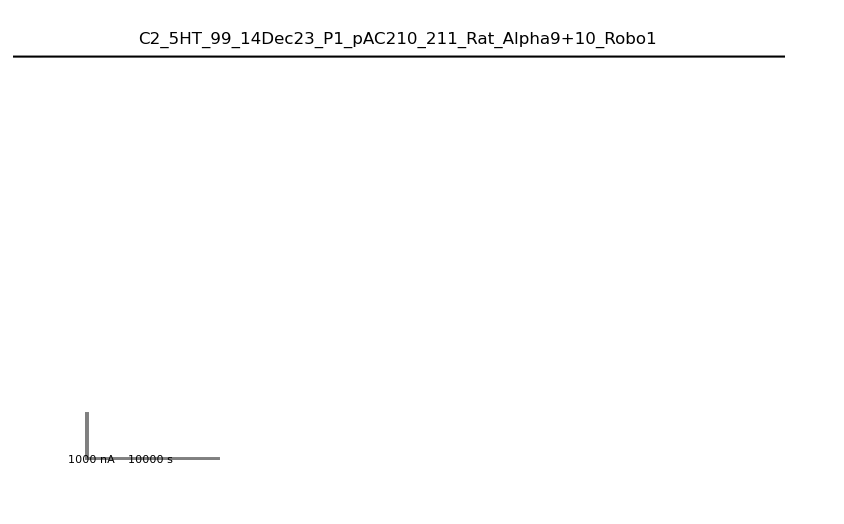

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


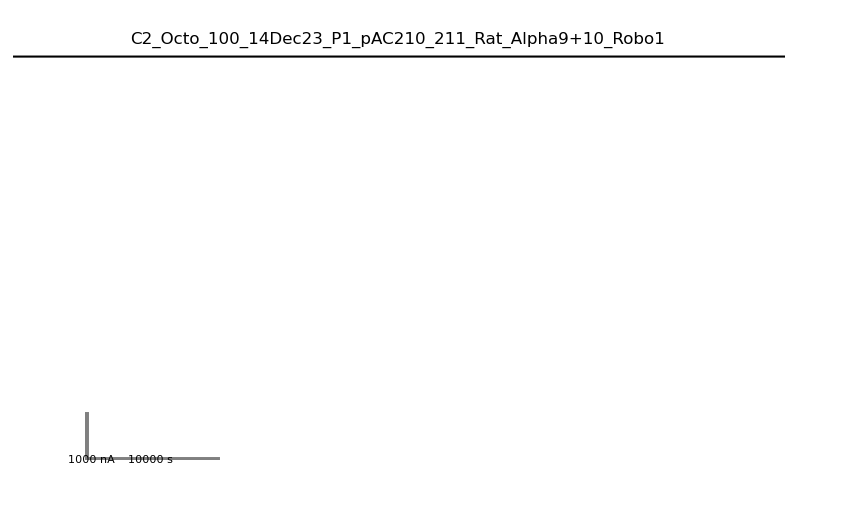

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


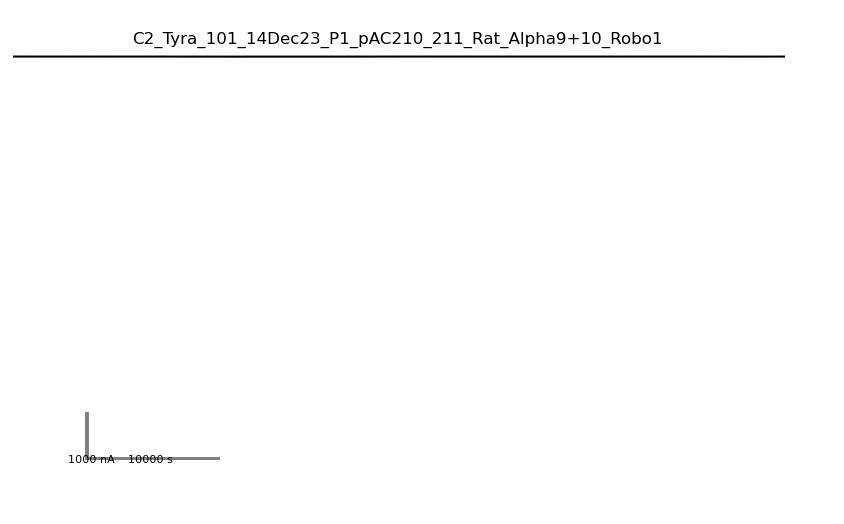

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


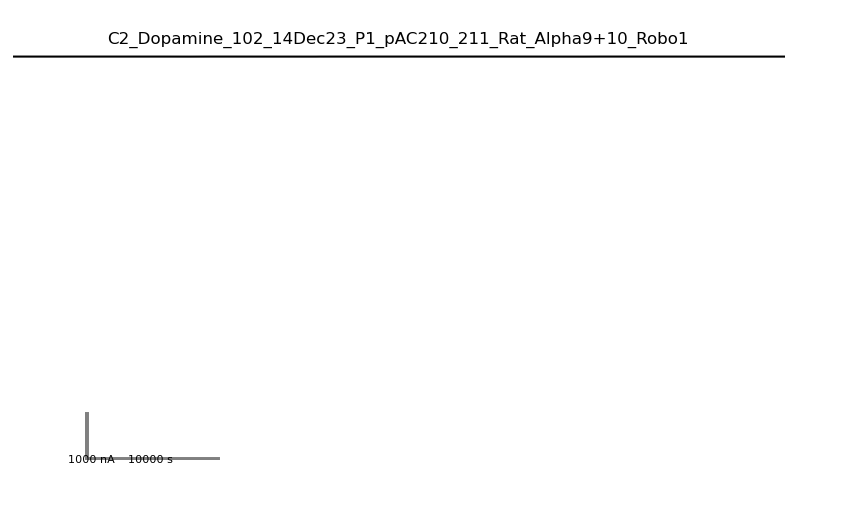

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


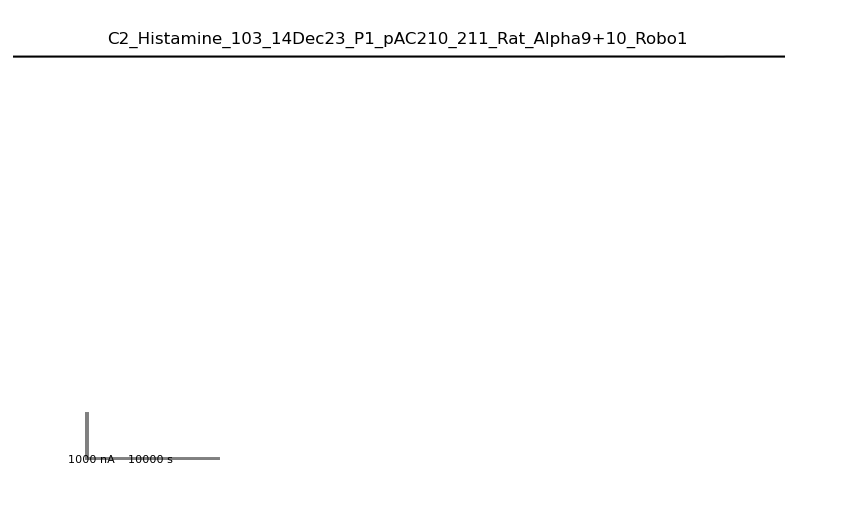

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


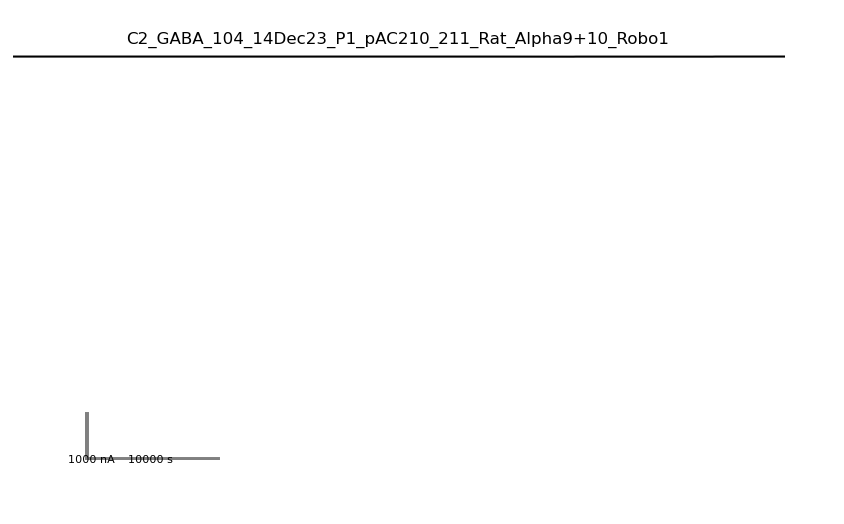

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


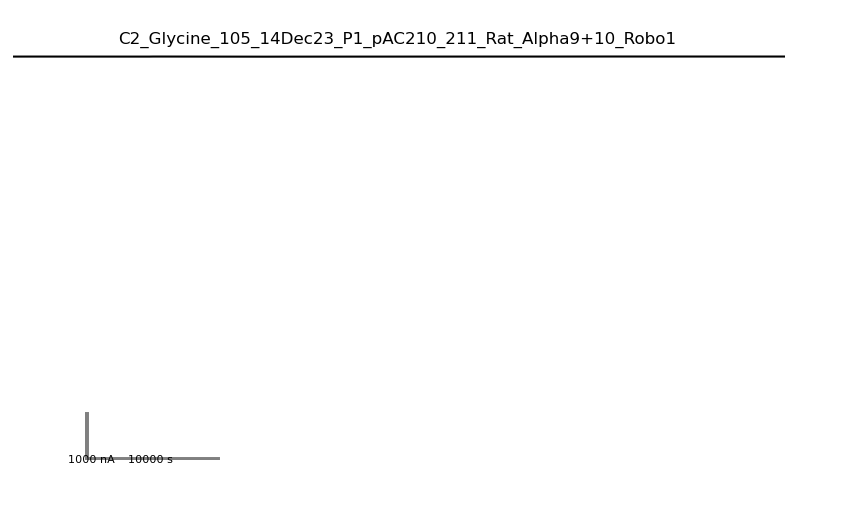

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


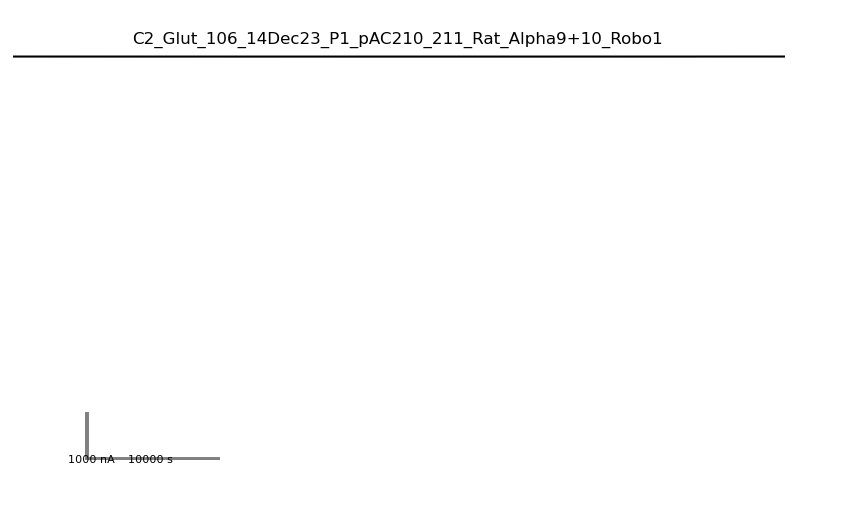

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


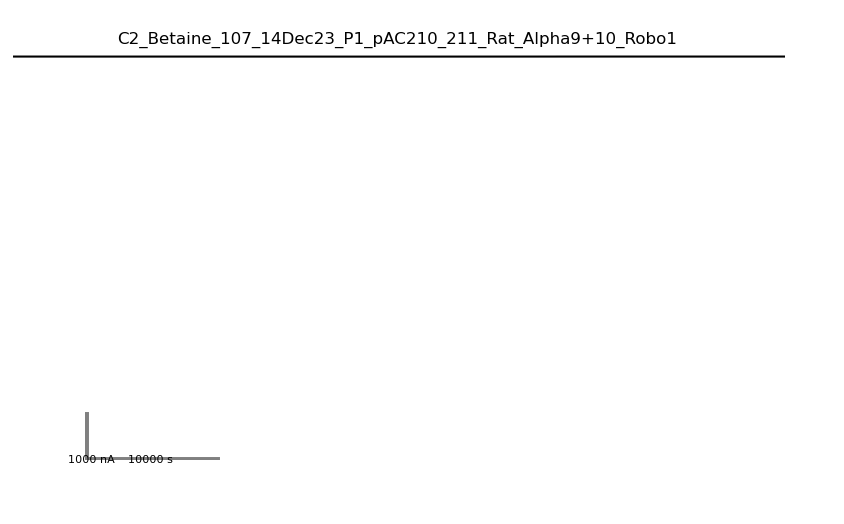

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


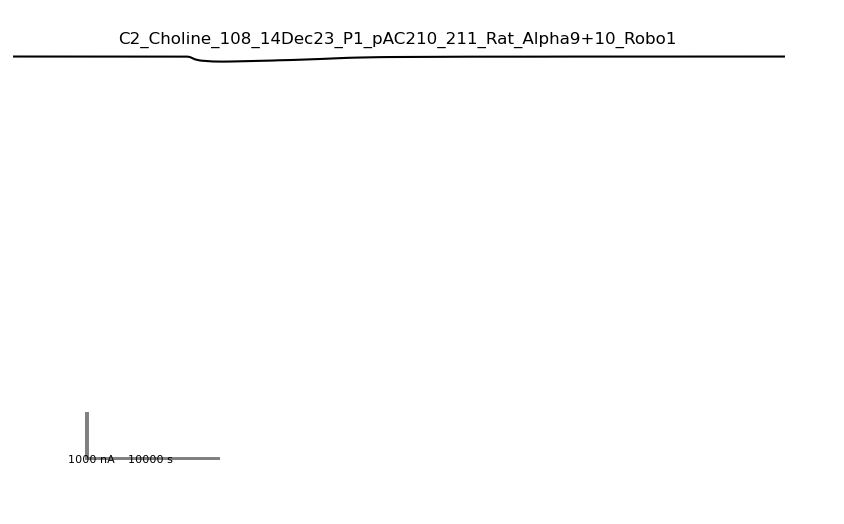

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


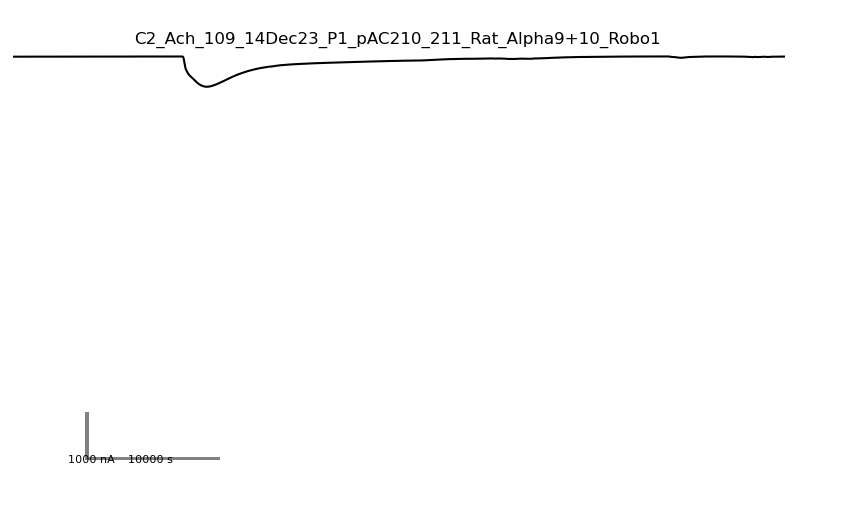

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


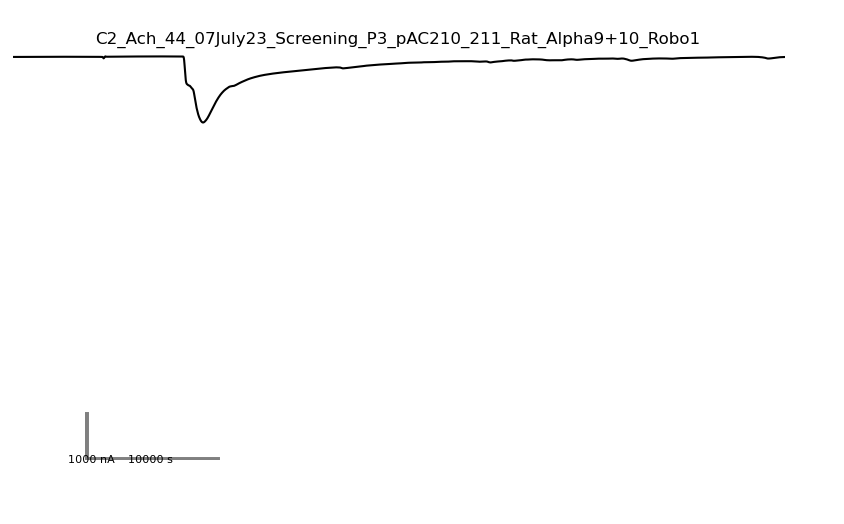

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


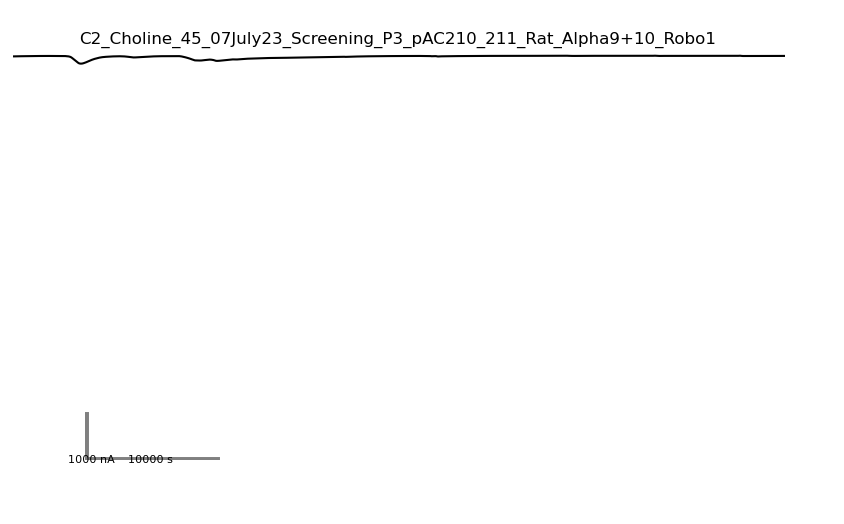

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


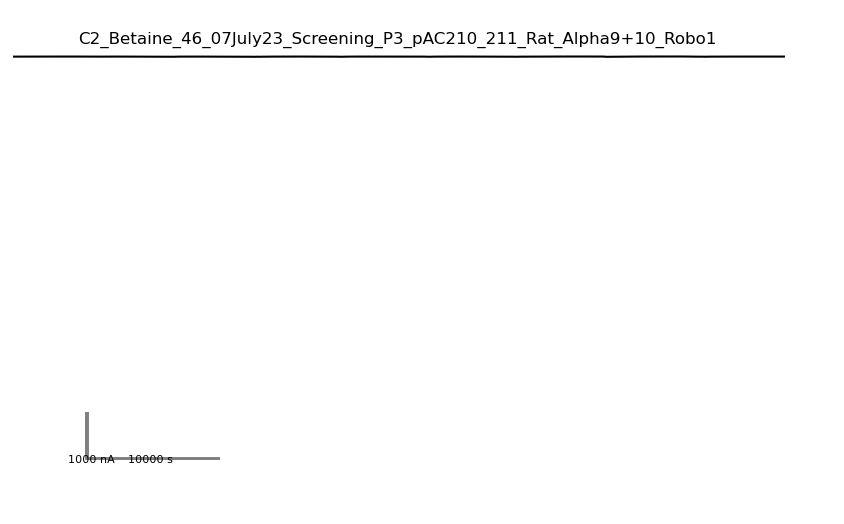

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


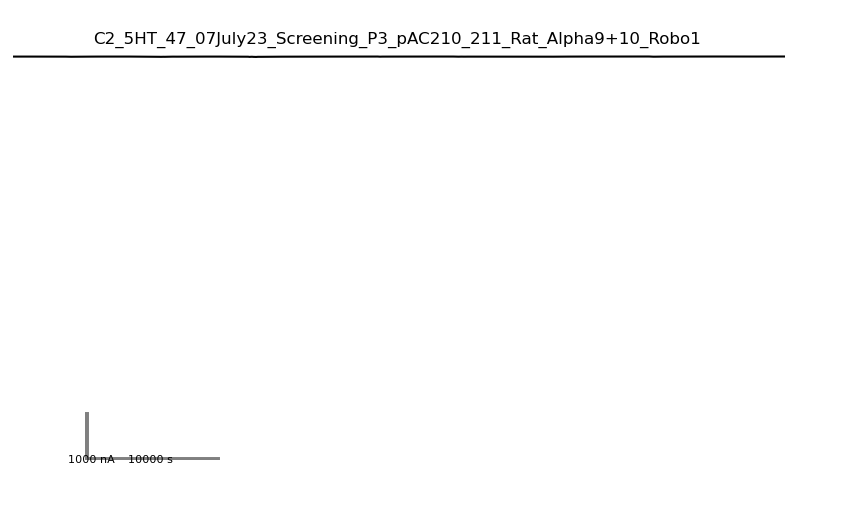

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


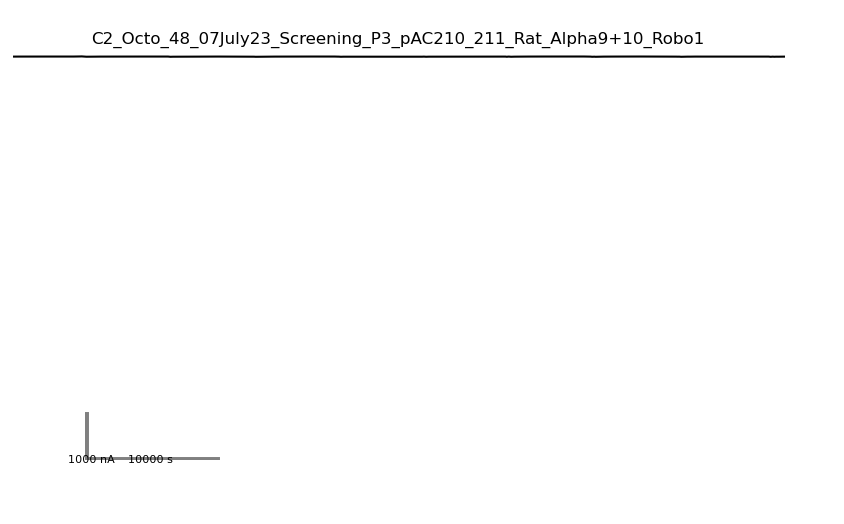

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


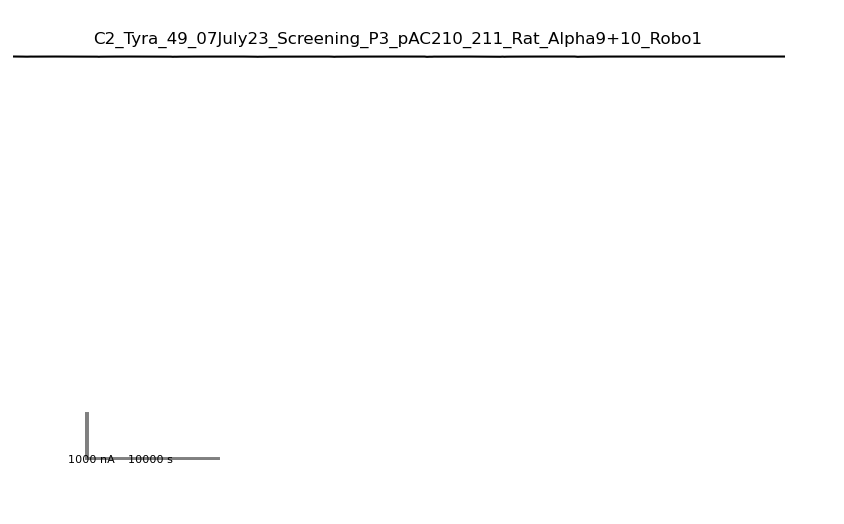

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


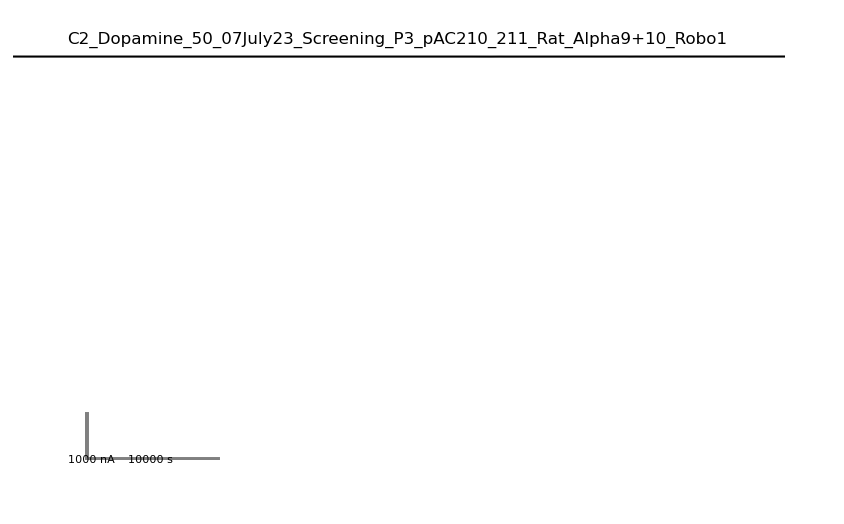

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


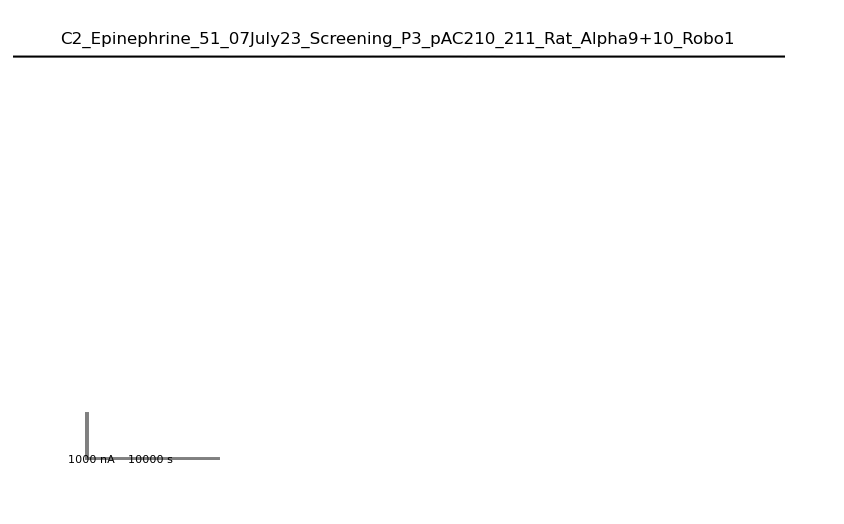

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


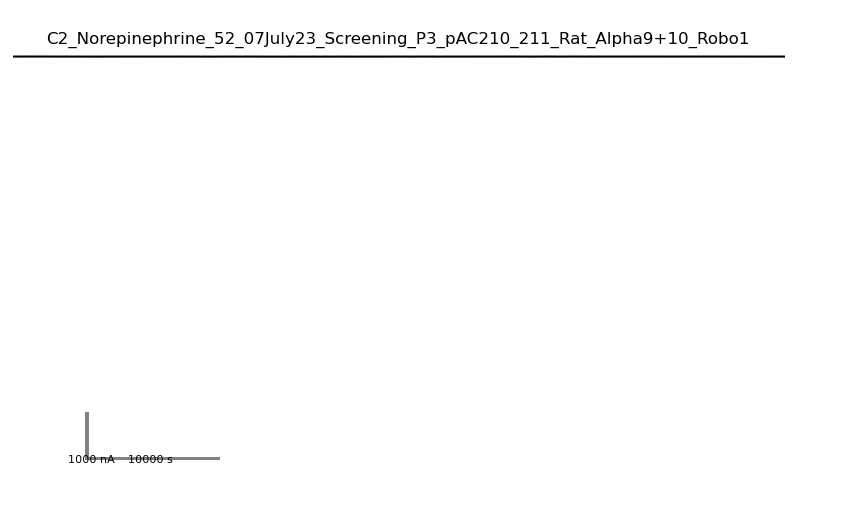

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


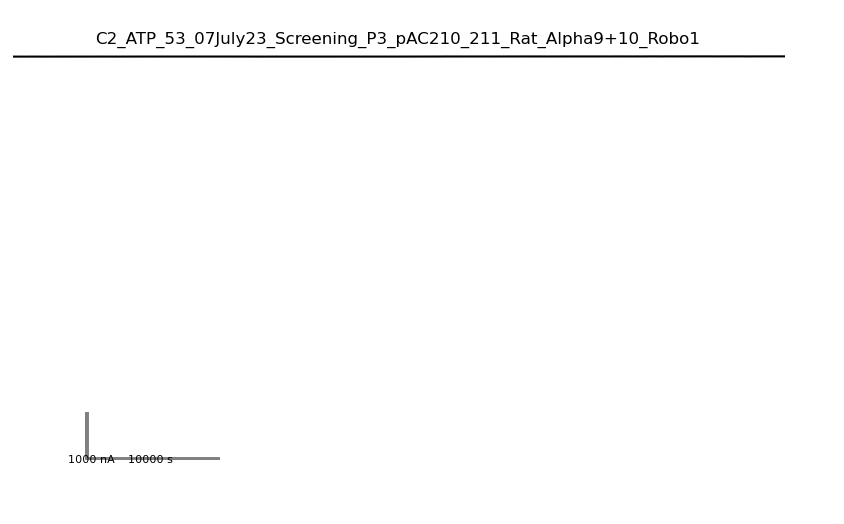

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


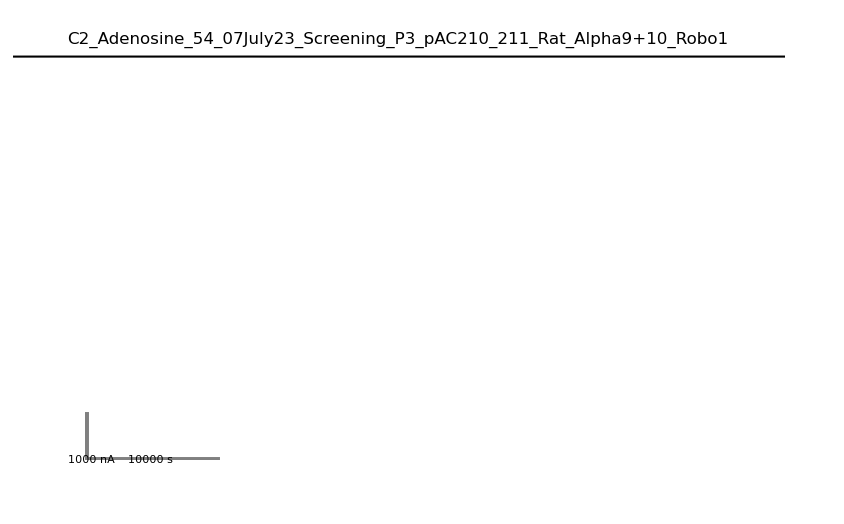

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


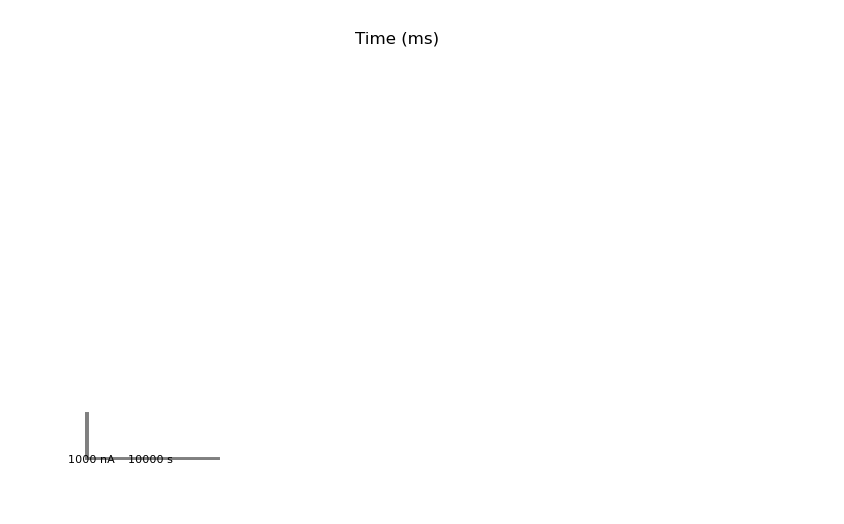

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


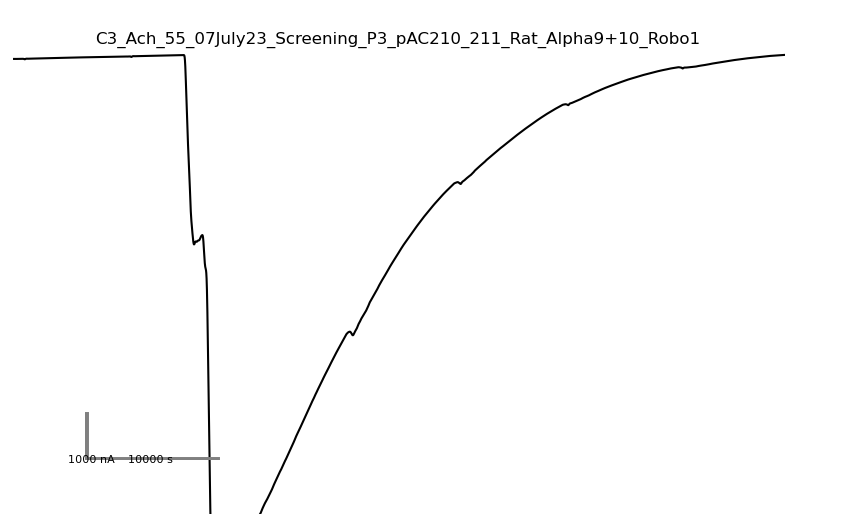

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


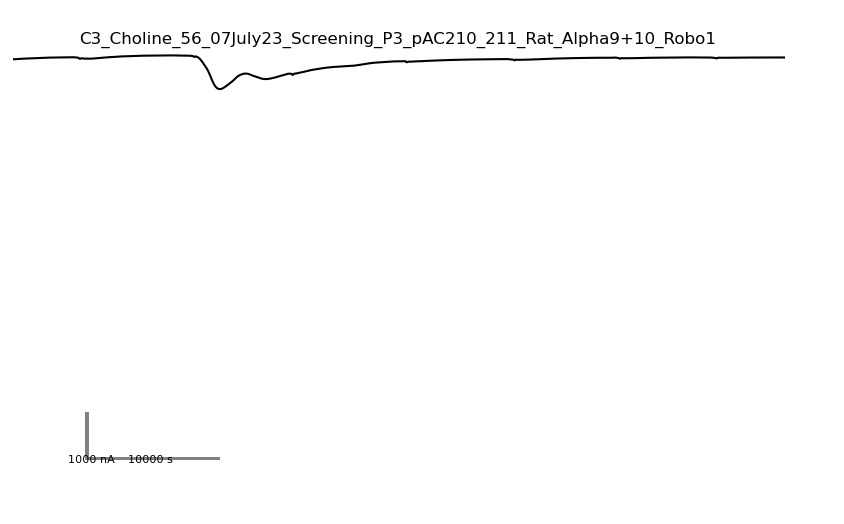

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


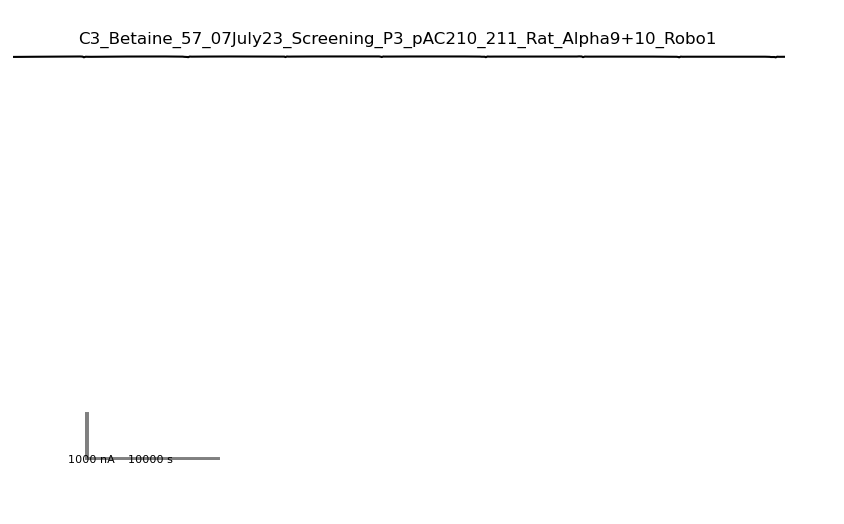

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


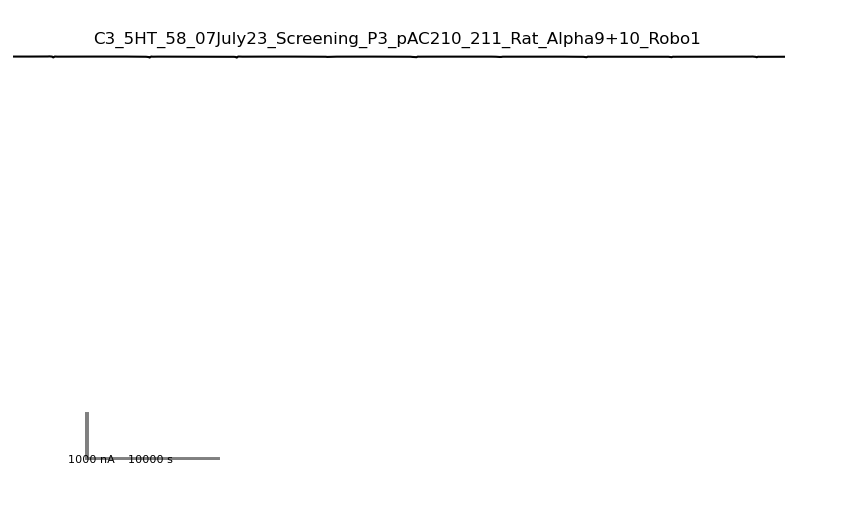

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


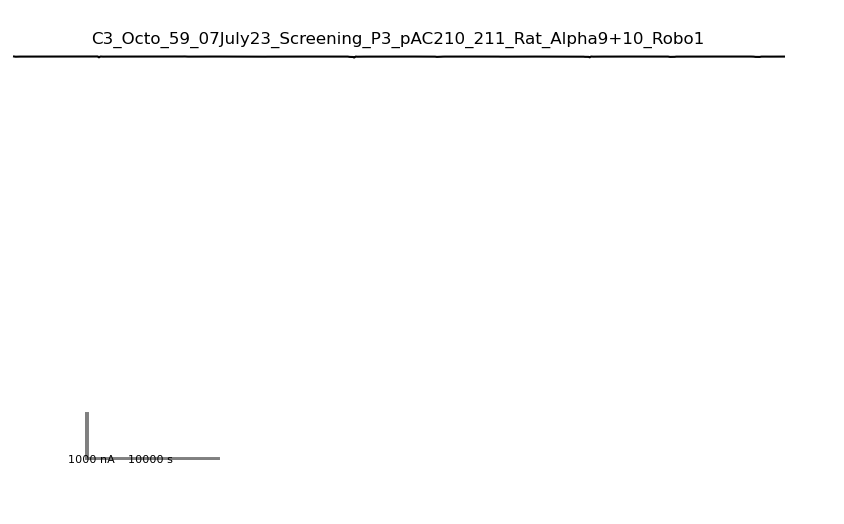

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


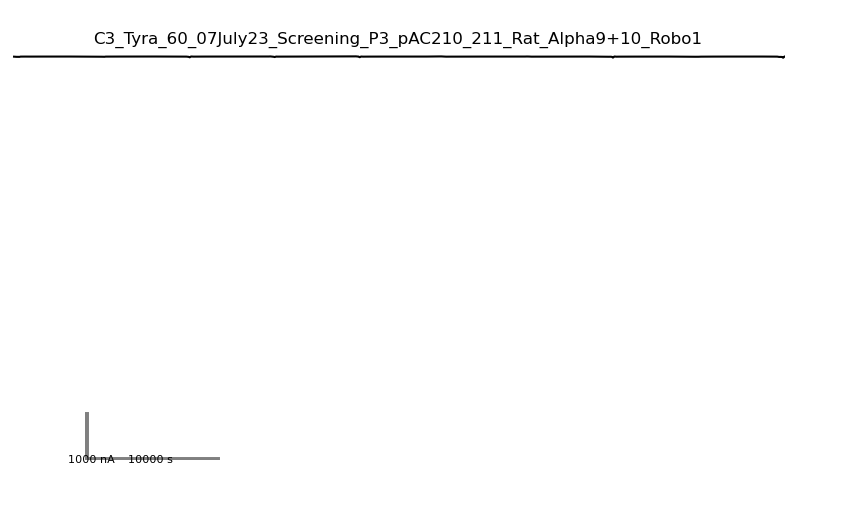

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


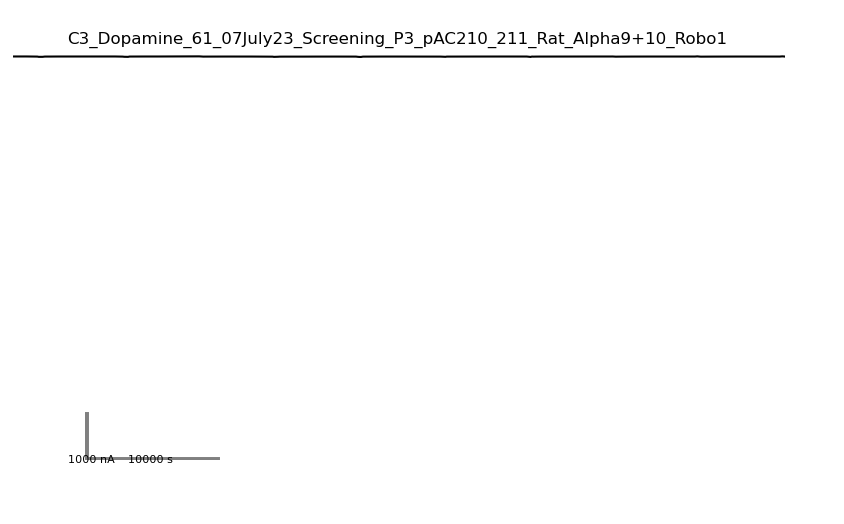

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


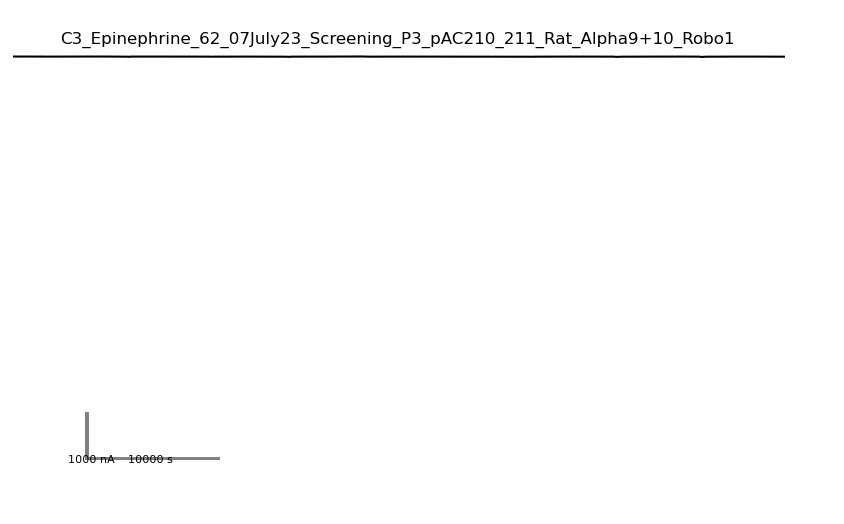

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


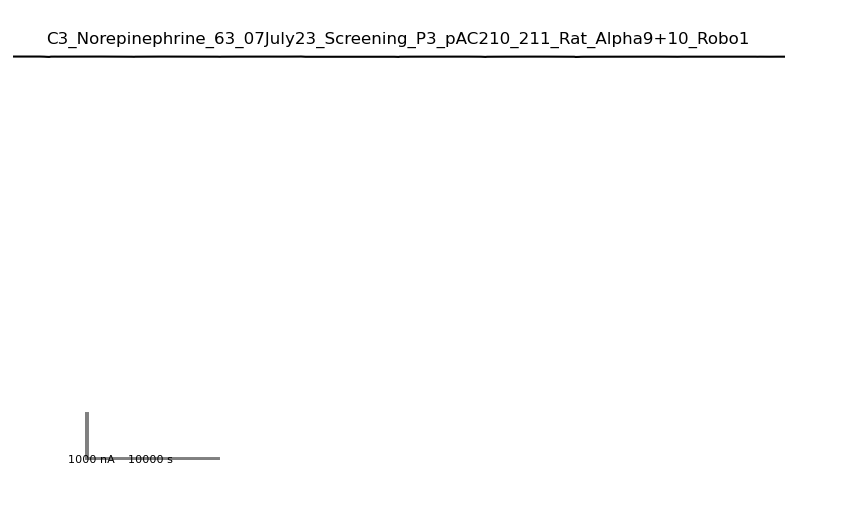

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


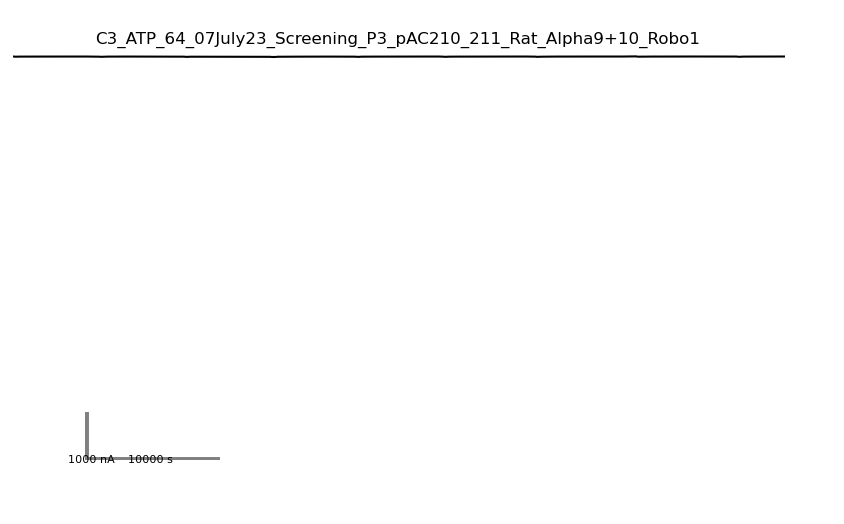

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


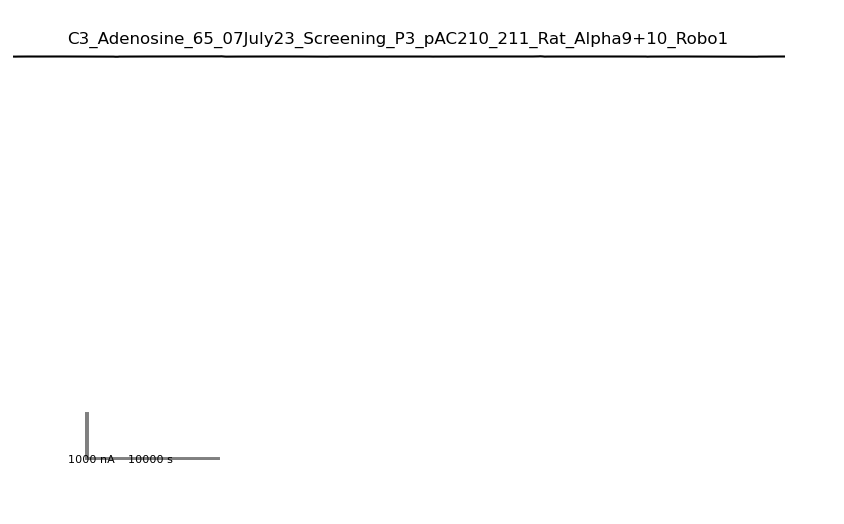

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


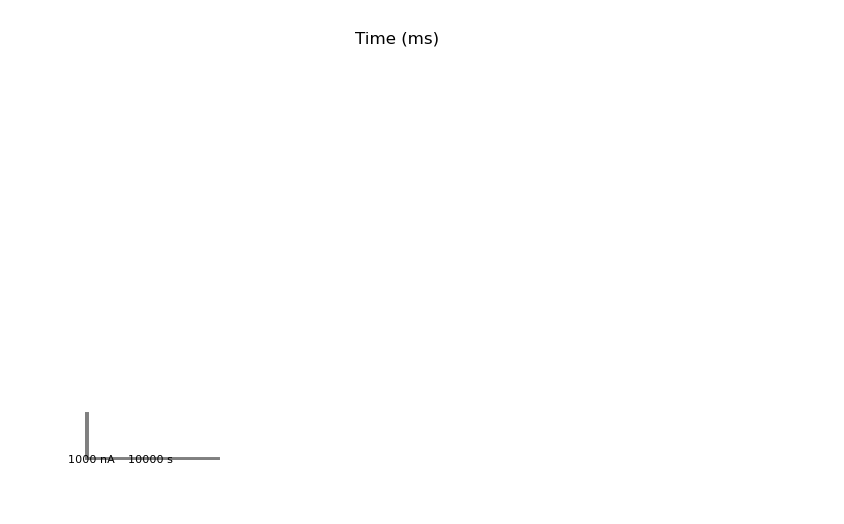

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


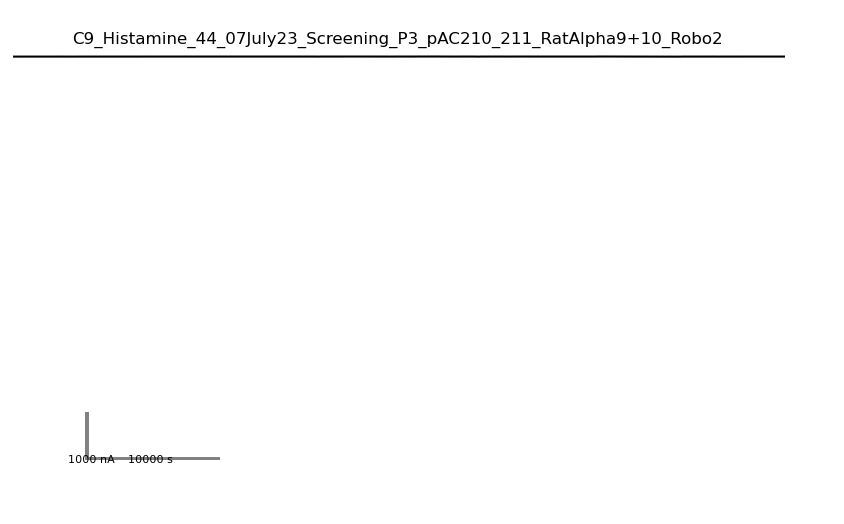

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


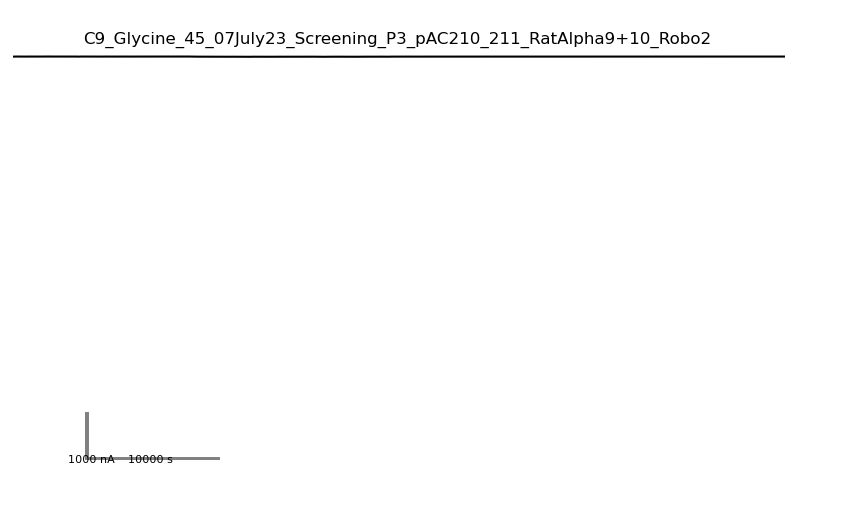

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


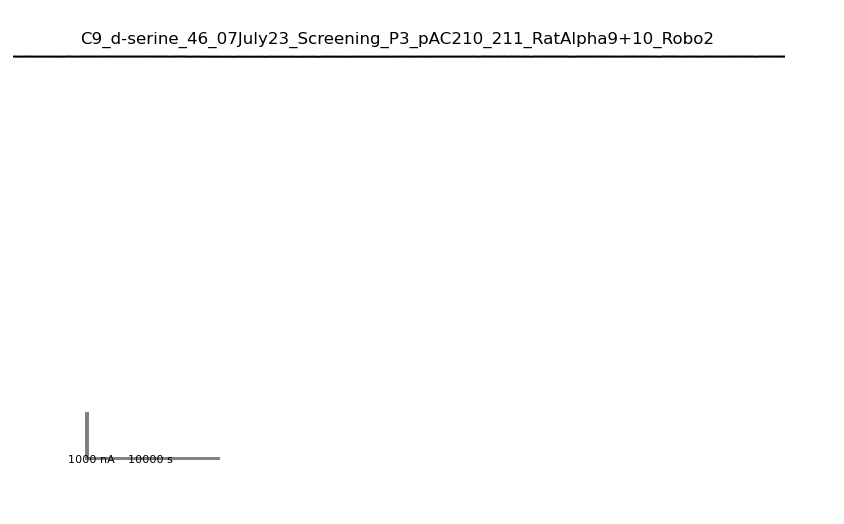

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


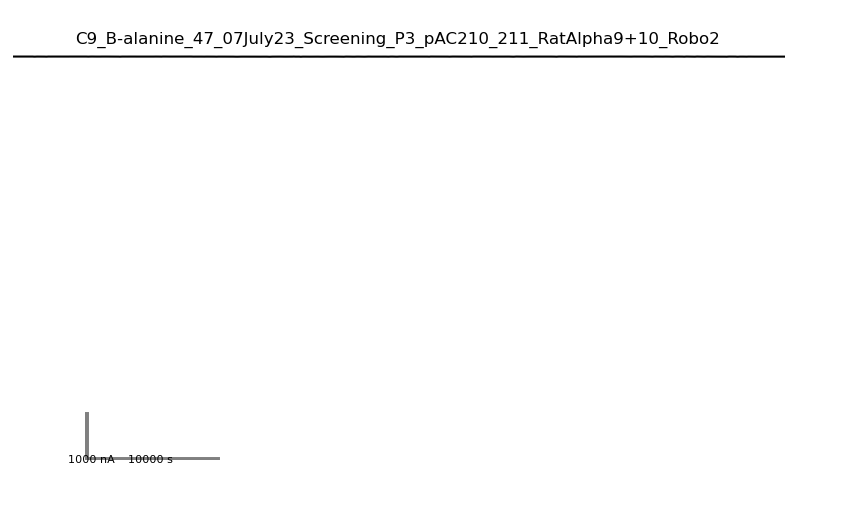

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


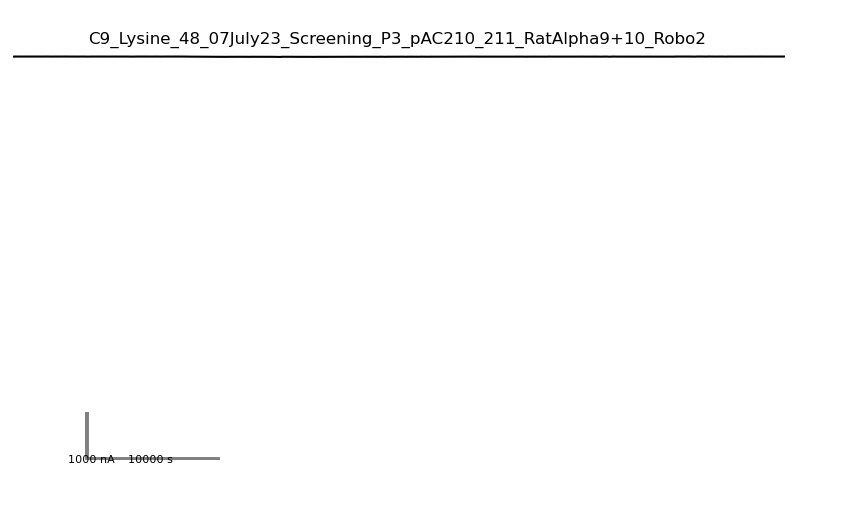

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


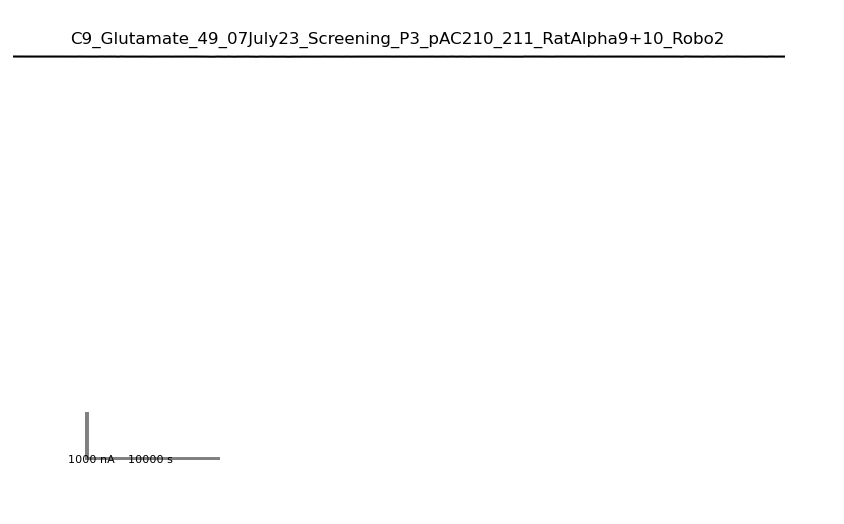

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


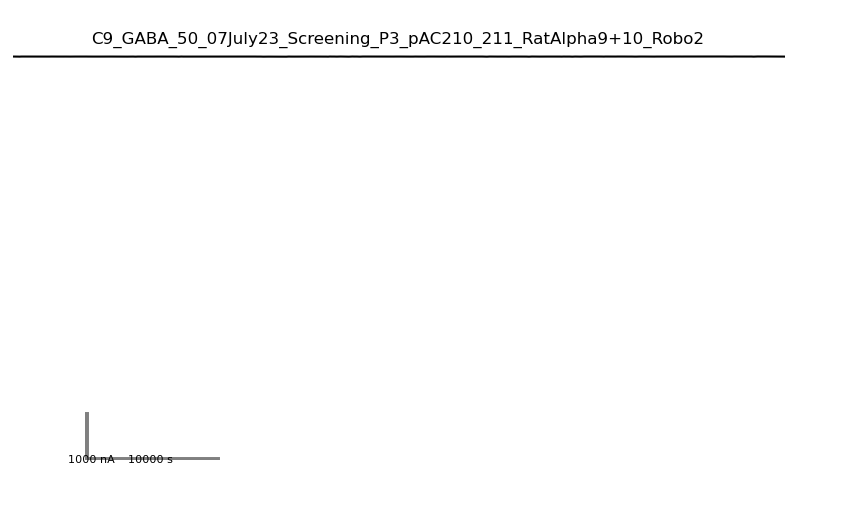

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


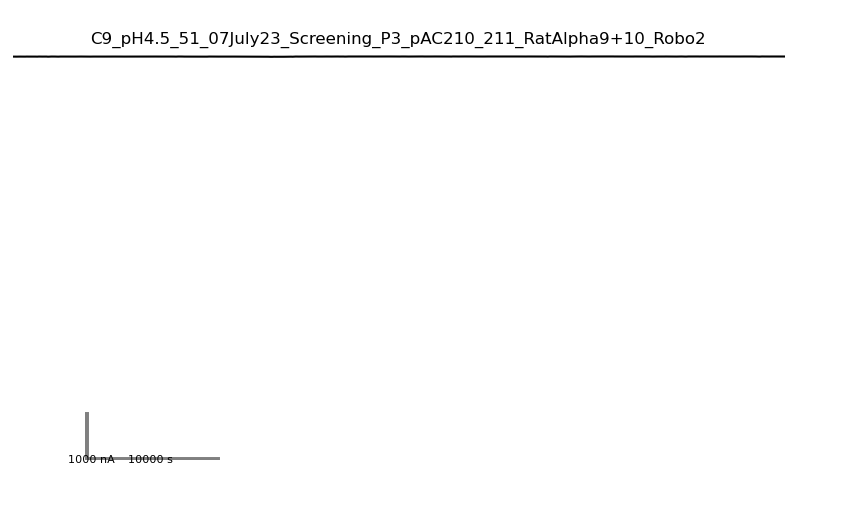

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


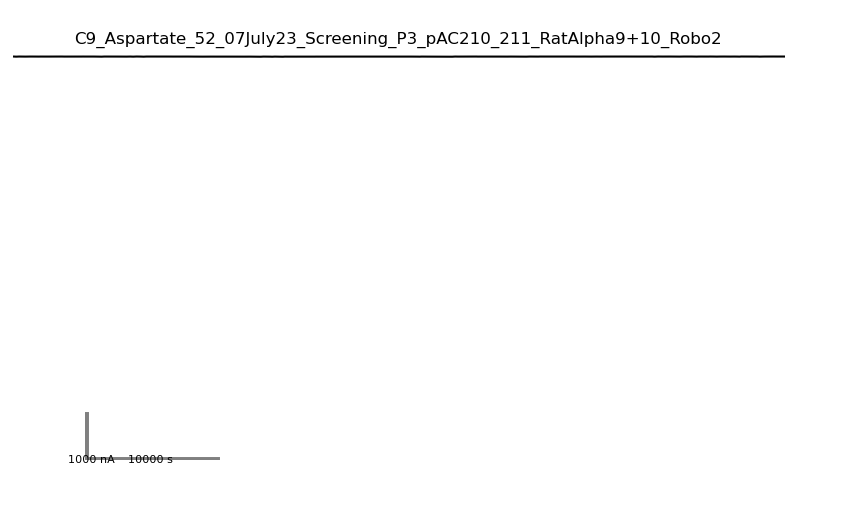

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


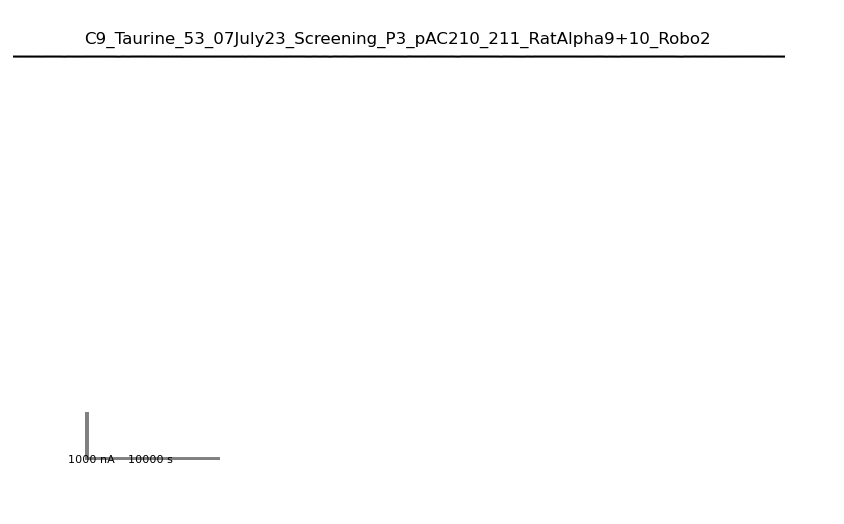

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


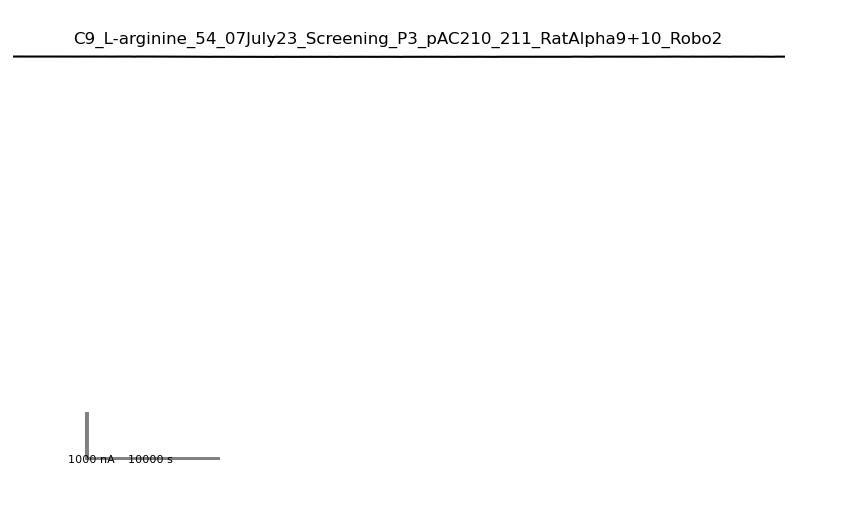

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


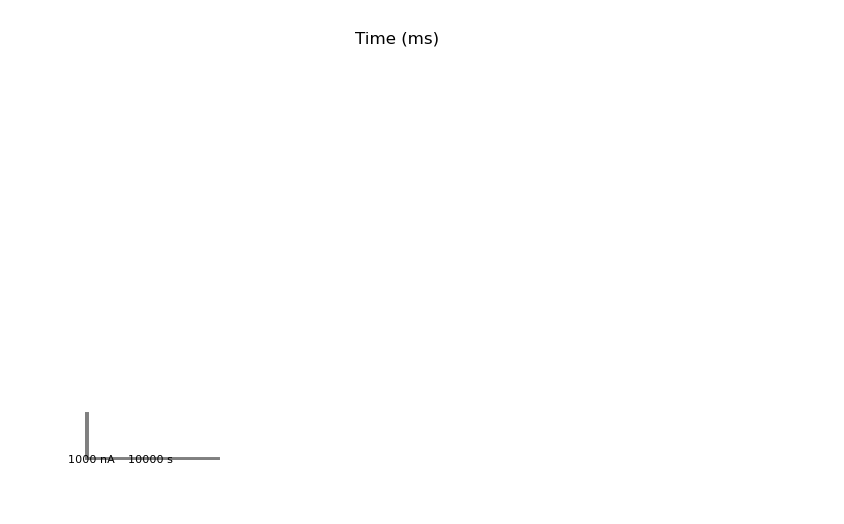

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


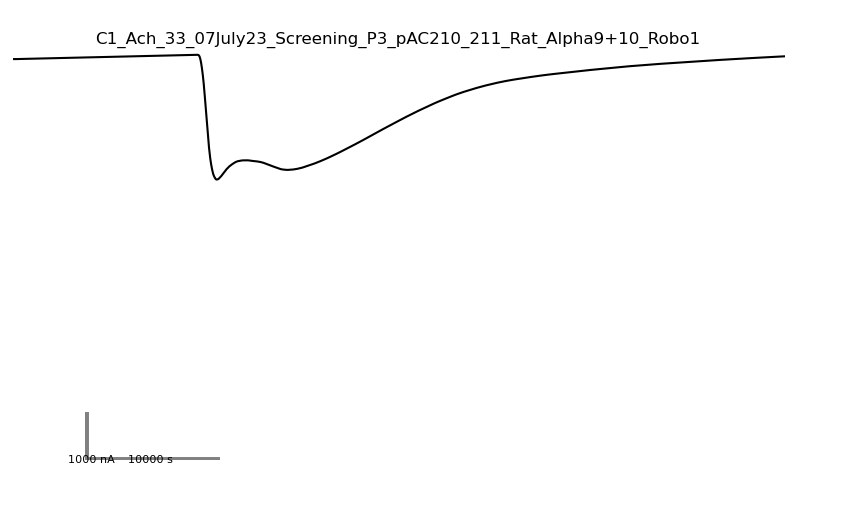

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


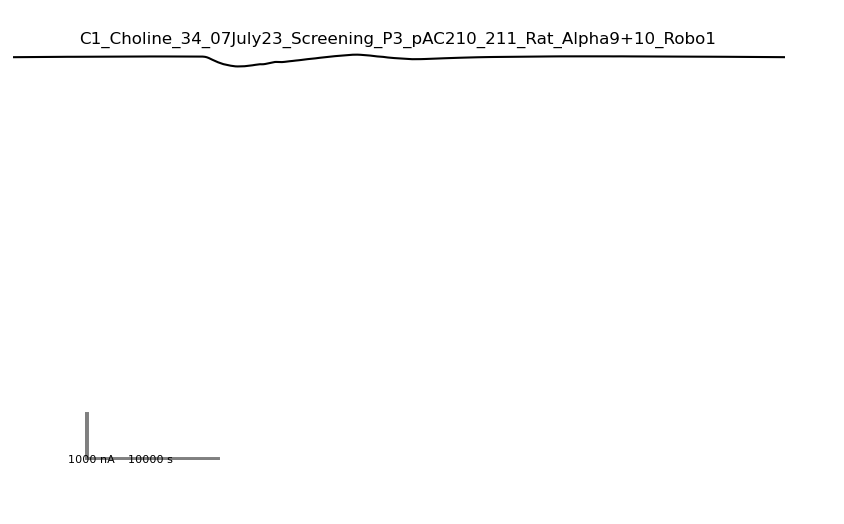

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


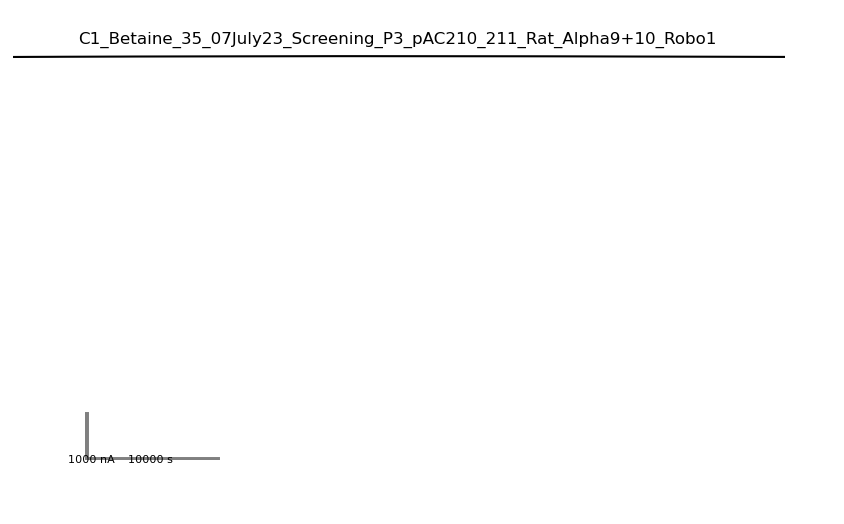

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


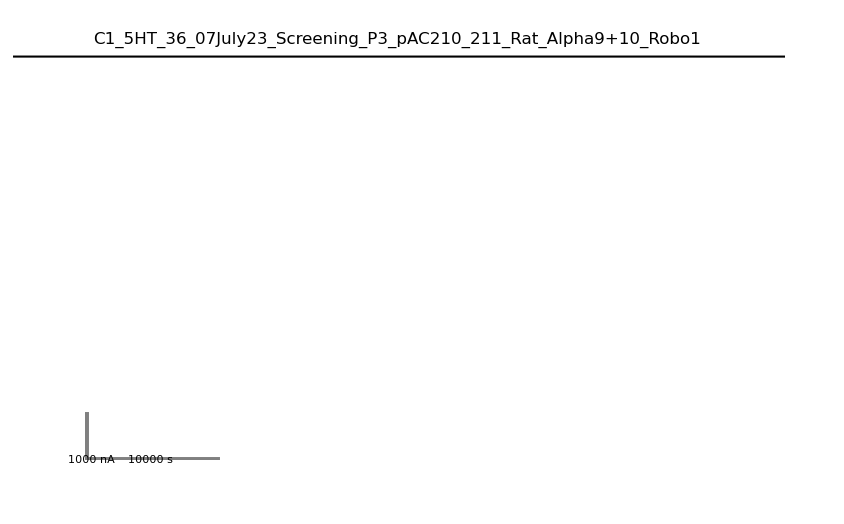

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


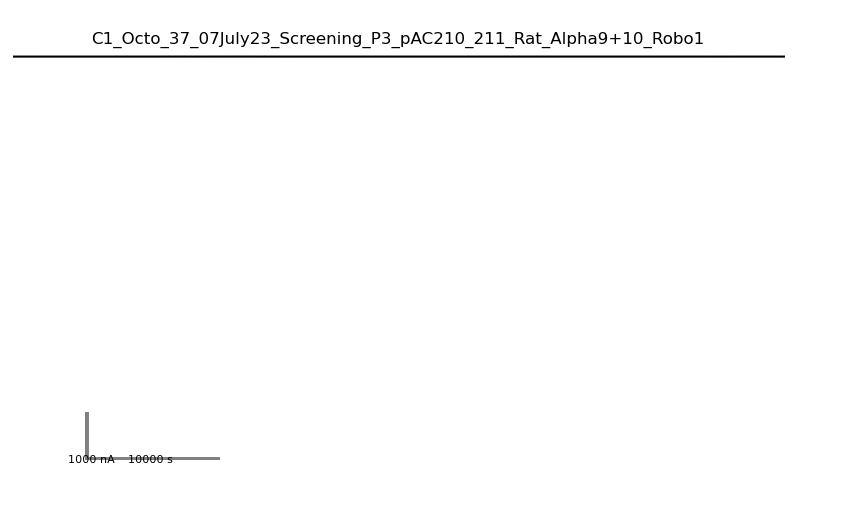

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


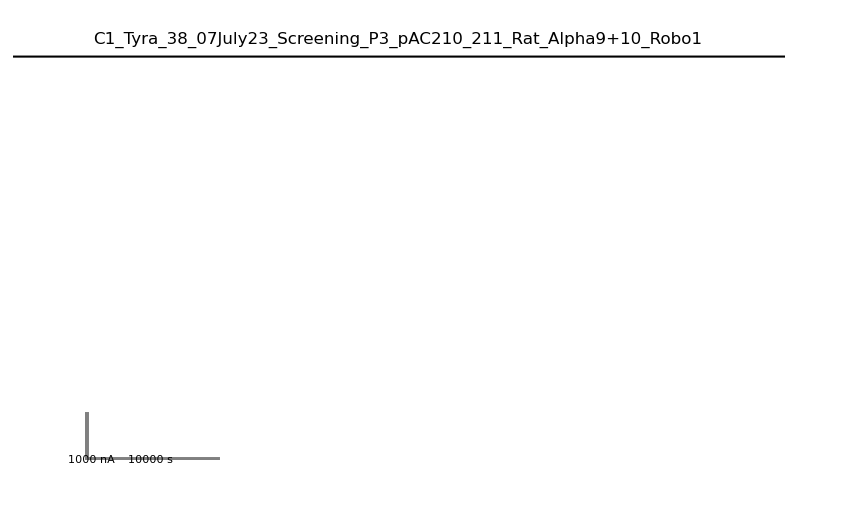

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


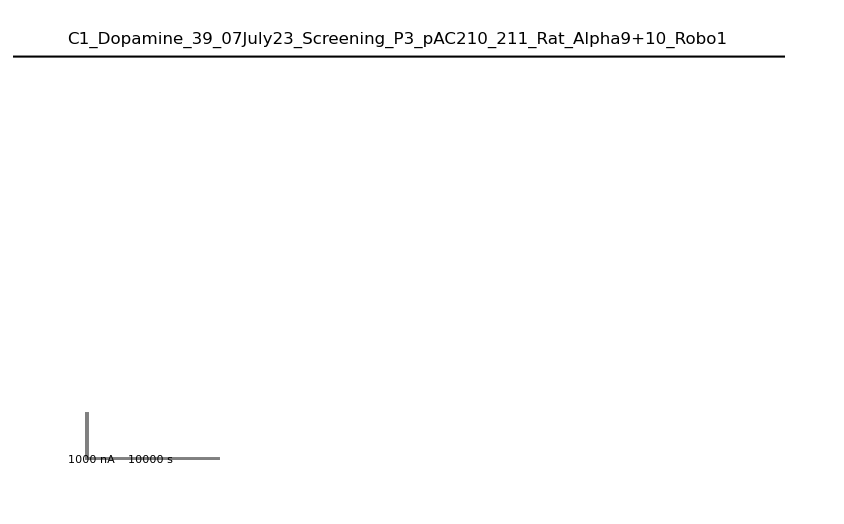

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


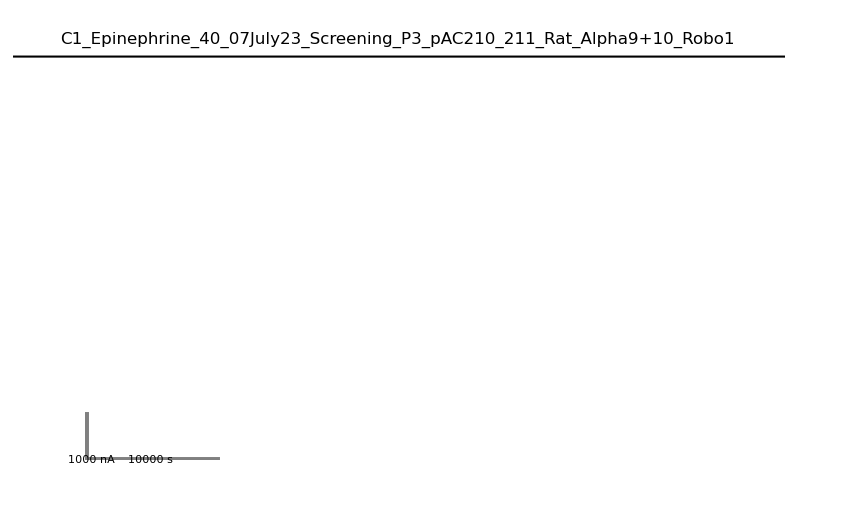

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


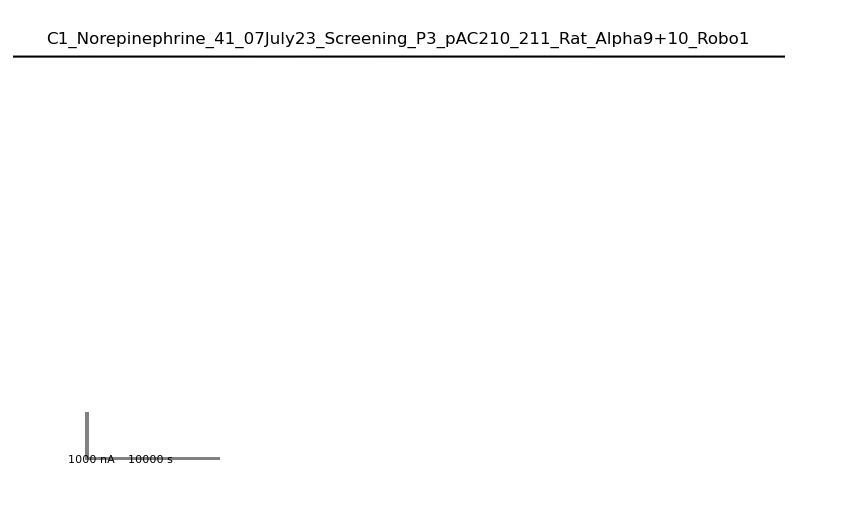

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


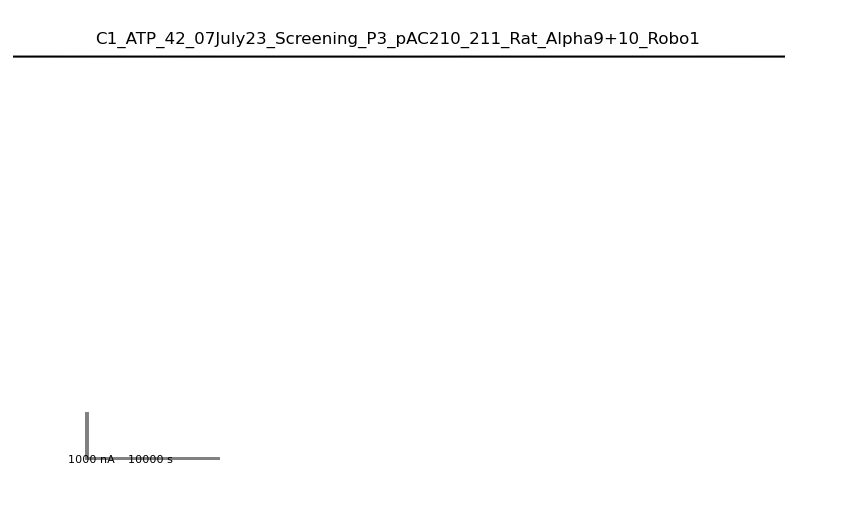

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


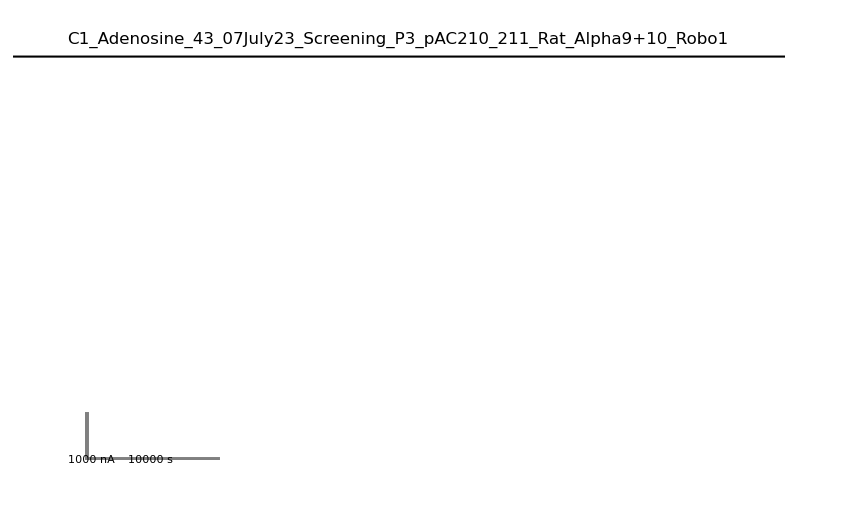

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


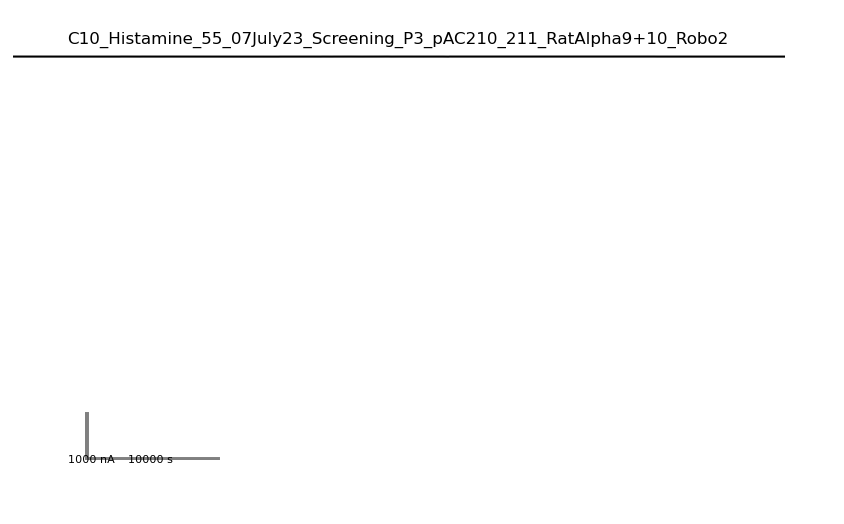

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


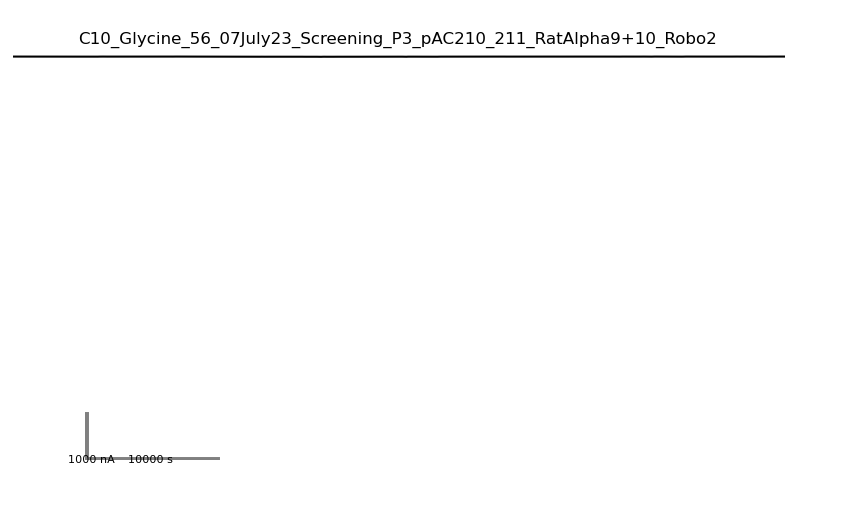

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


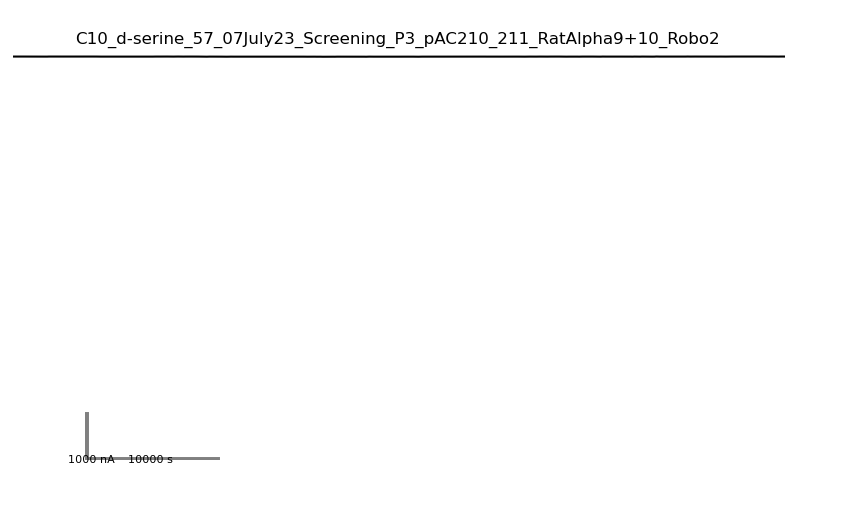

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


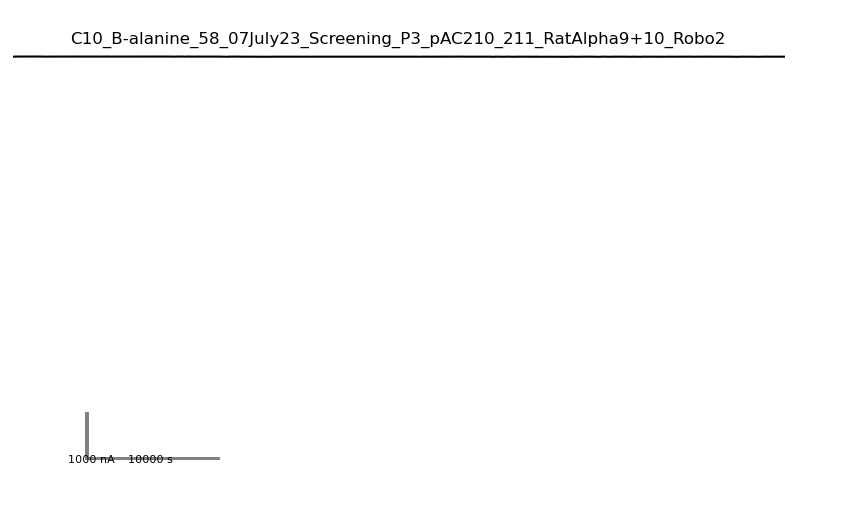

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


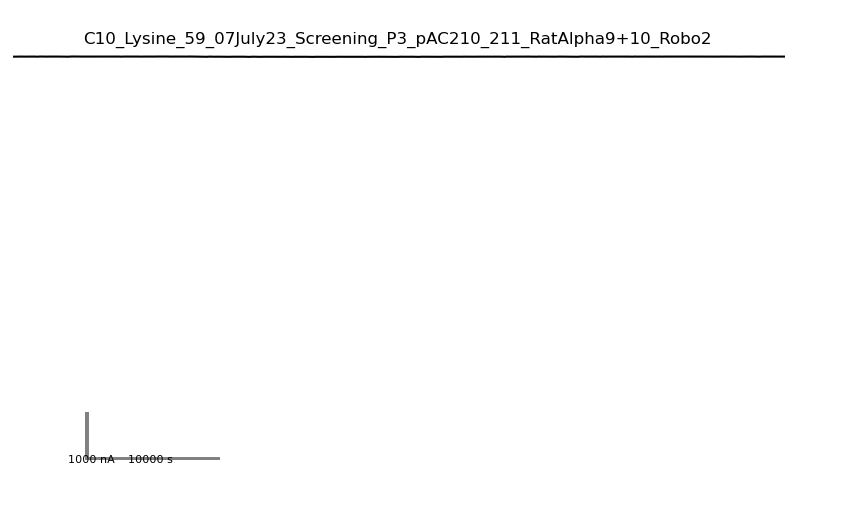

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


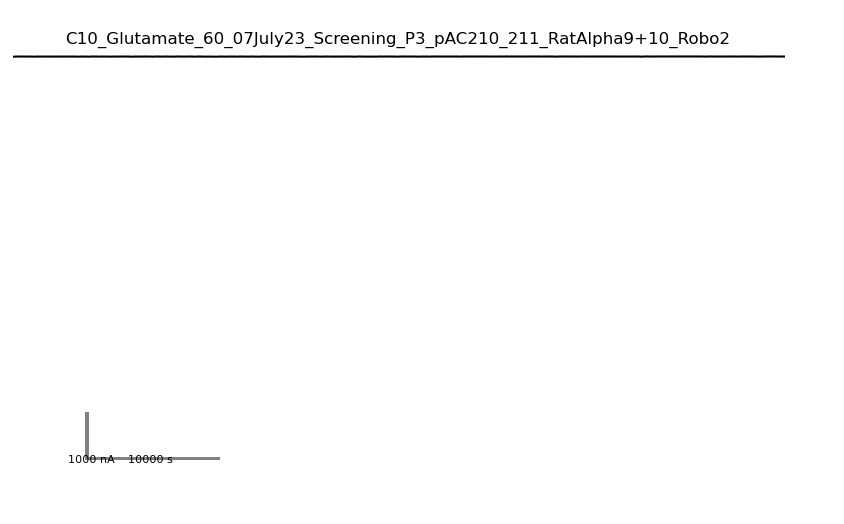

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


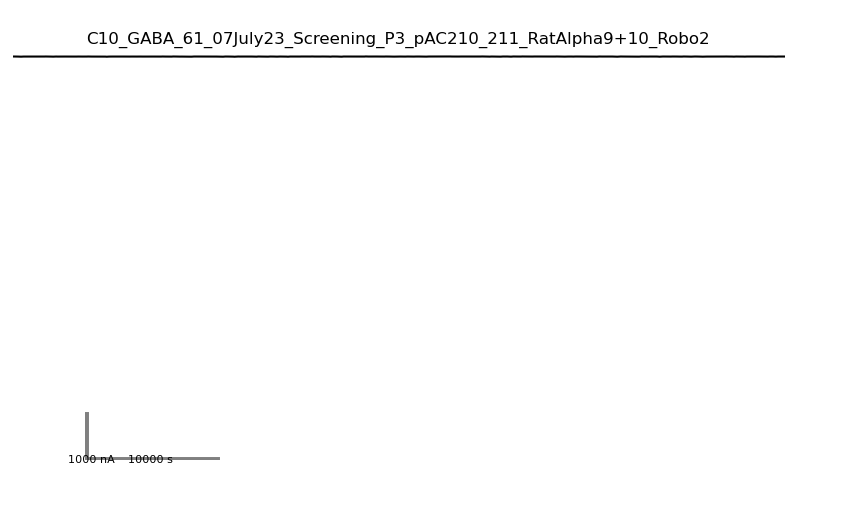

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


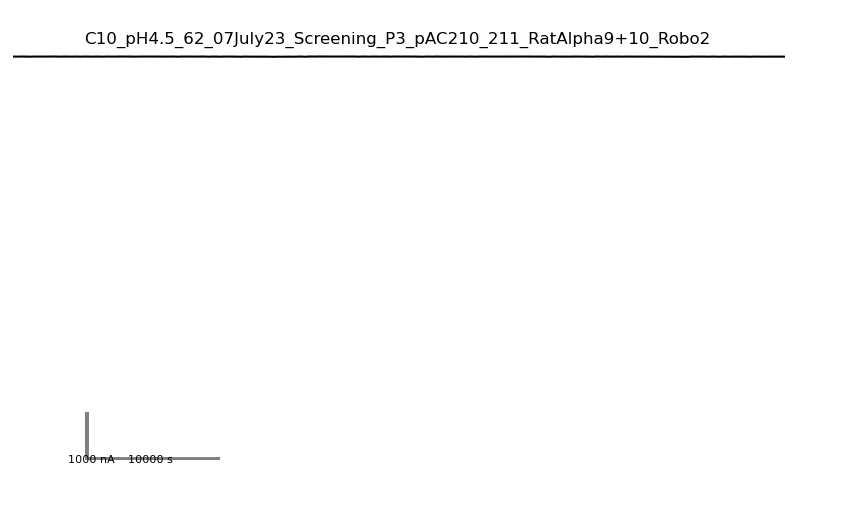

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


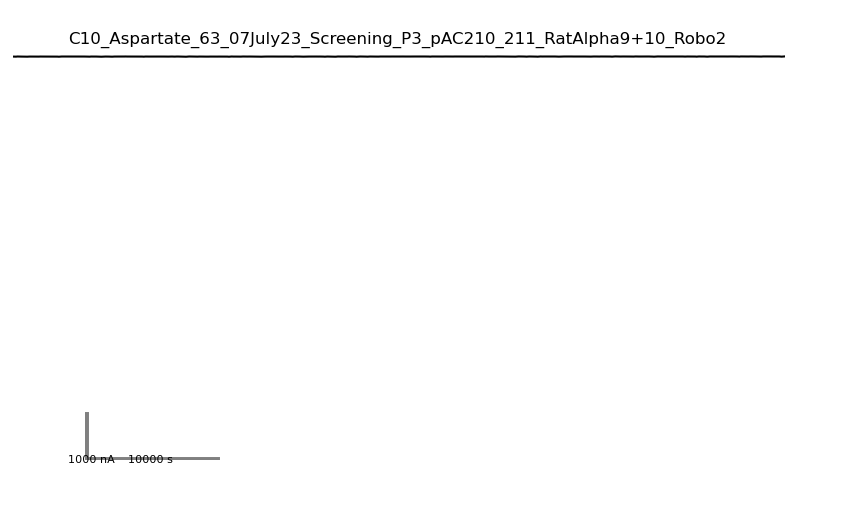

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


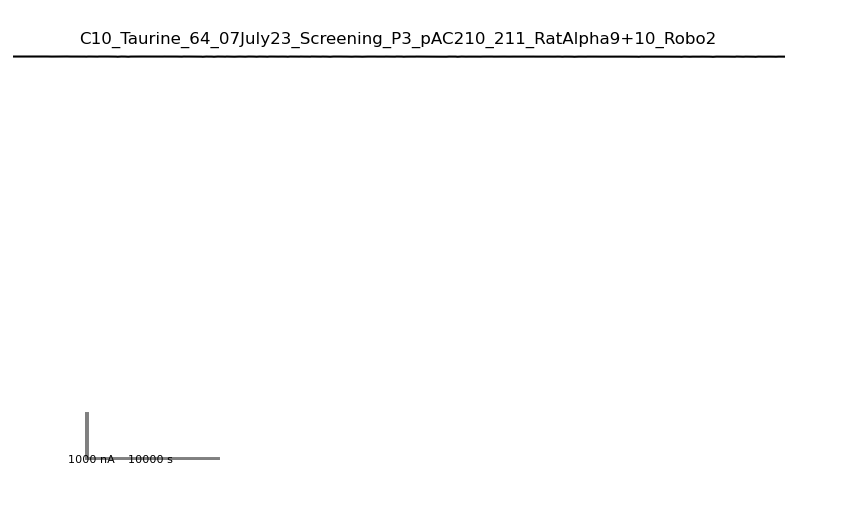

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


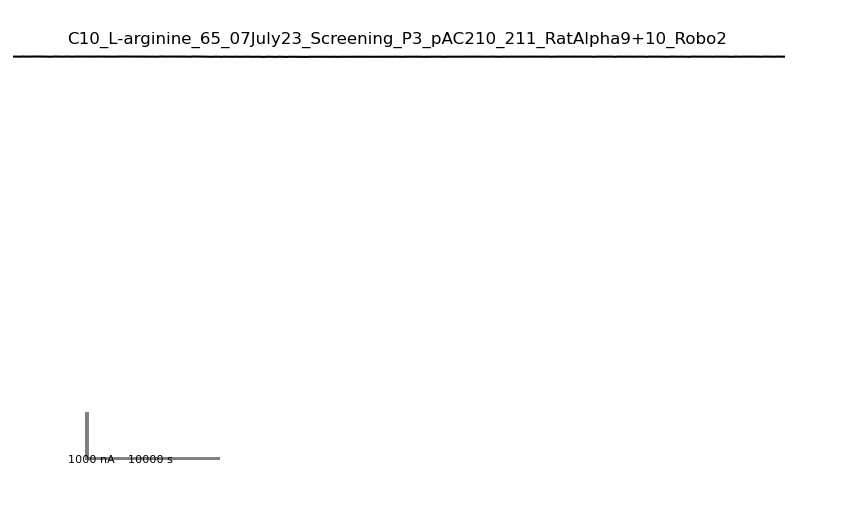

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


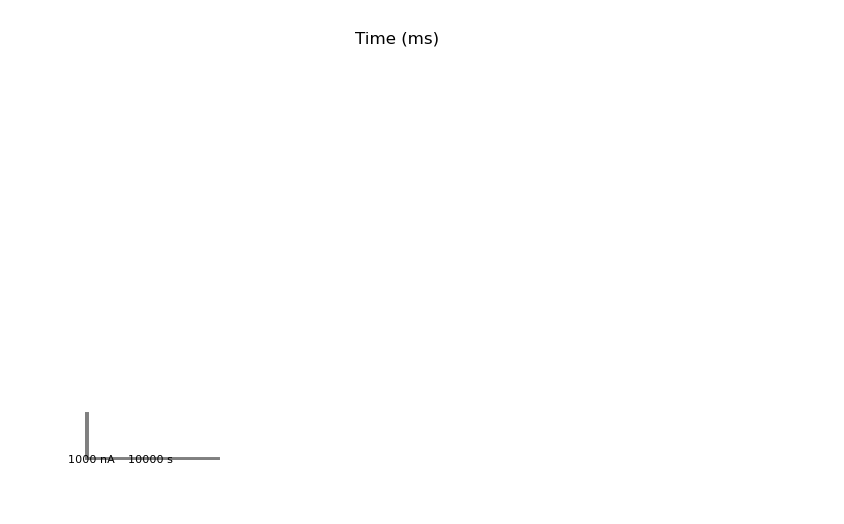

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/ACR21_LGC4/May_Update/Example_Traces/Rat_Alpha9_Alpha10_pAC210_211/output_plots folder.


In [62]:
#loop over each oocyte
# Initialize an empty set to store unique common prefixes
unique_prefixes = set()

# Iterate over column headers
for column_header in df.columns:
    # Extract the first two letters of each header
    prefix = column_header[:2]
    # Add the prefix to the set
    unique_prefixes.add(prefix)

# Convert the set to a list
unique_prefixes_list = list(unique_prefixes)

# Initialize an empty dictionary to store subset DataFrames for each prefix
subset_dfs = {}

# Iterate over unique common prefixes
for prefix in unique_prefixes_list:
    # Filter columns that start with the current prefix
    subset_df = df.filter(regex=f'^{prefix}', axis=1)
    # Store the subset DataFrame in the dictionary with the prefix as the key
    subset_dfs[prefix] = subset_df

    subset_df = subset_df.apply(pd.to_numeric, errors='coerce')
    # Delete the first 5 rows
    subset_df = subset_df.iloc[150:]

    # SAVE PLOTS?
    save = True  # Change to False if you don't want to save the plots
    # Define scale
    maxy = - subset_df.min(numeric_only=True, skipna=True).min(skipna=True) + 20  #find smallest value in df
    maxy = 10000 #if you want defined y
    maxx = (len(subset_df) *2) 
    scale_bar_length = 10*1000 #seconds
    scale_bar_height = round(maxy / 10) #n amps
    # Calculate the position and size of the scale bar

    # Directory to save PDF files
    path2 = Path(path)  # use your path
    output_folder = path2 / 'output_plots'

    # Create the output folder if it doesn't exist
    output_folder.mkdir(parents=True, exist_ok=True)

    # Define a function to check if a value is numeric
    def is_numeric(value):
        try:
            float(value)
            return True
        except ValueError:
            return False
    # Apply pd.to_numeric with a custom function to filter non-numeric values for the whole DataFrame
    subset_df = subset_df.apply(lambda x: pd.to_numeric(x, errors='coerce').where(x.apply(is_numeric)))

    # Drop rows with any NaN values
    #subset_df = subset_df.dropna()

    subset_df['Time (ms)'] = pd.to_numeric(subset_df.index, errors='coerce') *2


    # Create a copy of the DataFrame for plotting
    df_plot = subset_df.copy()

    # Plot each column in a separate figure
    for col in df_plot.columns:
        fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the width and height as needed
        fig.set_size_inches(10, 6)
        ax.plot(subset_df['Time (ms)'], df_plot[col], label=col, color='black')
        ax.set_ylim(-maxy, 100)
        ax.set_xlim(0, maxx)
        # Remove top and right axes lines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('nA')
        ax.set_title(col)
        # Create a mini-axes as a scale bar
        scale_bar_axes = fig.add_axes([0.2, 0.2, .75, .75])  # Adjust position and size as needed
        scale_bar_axes.plot([0, scale_bar_length], [0, 0], color='grey', linewidth=5)
        scale_bar_axes.plot([1, 1], [0, scale_bar_height], color='grey', linewidth=5)
        scale_bar_axes.set_xlim(0, maxx)
        scale_bar_axes.set_ylim(0, maxy)
        scale_bar_axes.axis('off')
        # Add text to the scale bar
        text_x_position = (scale_bar_length / 2)  # Center the text
        text_y_position = -5 # Adjust the vertical position
        text2_x_position = (scale_bar_height / 2)  # Center the text
        text2_y_position = 10  # Adjust the vertical position
        scale_bar_axes.text(text_x_position, text_y_position, f'{scale_bar_length} s', color='black', ha='center', va='center', fontsize=8)
        scale_bar_axes.text(text2_x_position, text2_y_position, f'{scale_bar_height} nA', color='black', ha='center', va='center', fontsize=8)

        if save:
            # Save the plot as a PDF in the output folder
            output_filepath = output_folder / f'{col}.pdf'
            plt.savefig(output_filepath, format='pdf')
            plt.show()
            plt.close()  # Close the current figure to release resources
            print(f'PDF files saved in the {output_folder} folder.')
        else:
            # If save is False, just display the plots without saving
            plt.show()


